<a id=toc></a>
<h1 style="padding: 35px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/T1D2yGny/167.jpg); background-size: 100% auto;background-position: 0px 0px; 
"><span style='color:white;'>Transfer Learning | Brain Tumor Classification</span></h1>

<center>
    <figure>
        <img src="https://cdn-images-1.medium.com/max/800/1*f1sodi17fNcObGBmIKgGGQ.gif" alt ="Brain Tumor MRI" style='width:55%;'>
        <figcaption>
            Source: <a href="https://www.ai-tech.systems/brain-tumor-detection/">AI Technology & Systems | Brain Tumor Detection</a>
        </figcaption>
    </figure>
</center>

## 🎯 Objective
The objective for this notebook is to explore the usage of transfer learning models, **namely EfficientNet V2 B0 and ViT-B16**, along with **ensembling methods** for solving the task of **classifying multiple types of brain tumors in patients**. The inspection of model performances post-training and selection process is also explored within this notebook. To you, the notebook visitor: I hope you find the contents insightful/useful. 


## 📁 Dataset
This dataset consists of a private collection of T1, contrast-enhanced T1, and T2 magnetic resonance images separated by brain tumor type. The images were collected without any type of marking or patient identification, interpreted by radiologists and provided for study purposes. The images are separated by astrocytoma, carcinoma, ependymoma, ganglioglioma, germinoma, glioblastoma, granuloma, medulloblastoma, meningioma, neurocytoma, oligodendroglioma, papilloma, schwannoma and tuberculoma.

**For more information check the following:**
> - [Kaggle | Brain Tumor MRI Images 44 Classes](https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c?sort=published)
> - [Dataset Author | Fernando Feltrin](https://www.kaggle.com/fernando2rad)

## 🧠 What Are Brain Tumors?

<center>
    <figure>
        <img src="https://my.clevelandclinic.org/-/scassets/images/org/health/articles/6149-brain-tumor" alt ="Brain Tumor" style='width:40%;'>
        <figcaption>
            Source: <a href="https://my.clevelandclinic.org/health/diseases/6149-brain-cancer-brain-tumor">Cleveland Clinic | Brain Tumor Illustration</a>
        </figcaption>
    </figure>
</center>

A brain tumor is a cancerous or non-cancerous mass or growth of abnormal cells in the brain. Nearby locations include nerves, the pituitary gland, the pineal gland, and the membranes that cover the surface of the brain. Brain tumors that begin in the brain are called primary brain tumors. Sometimes, cancer spreads to the brain from other parts of the body. These tumors are known as secondary brain tumors, also called metastatic brain tumors.

### <u>Symptoms</u>
General signs and symptoms caused by brain tumors may include:
> - Headache or pressure in the head that is worse in the morning
> - Headaches that happen more often and seem more severe
> - Headaches that are sometimes described as tension headaches or migraines
> - Nausea or vomiting
> - Eye problems, such as blurry vision, seeing double or losing sight on the sides of your vision
> - Losing feeling or movement in an arm or a leg
> - Trouble with balance
> - Speech problems
> - Feeling very tired
> - Confusion in everyday matters
> - Memory issues
> - Having trouble following simple commands
> - Personality or behavior changes
> - Seizures, especially if there is no history of seizures
> - Hearing problems
> - Dizziness or a sense that the world is spinning, also called vertigo
> - Feeling very hungry and gaining weight

**For more information see the following:**
> - [Mayo Clinic | Brain tumor](https://www.mayoclinic.org/diseases-conditions/brain-tumor/symptoms-causes/syc-20350084)
> - [Cleveland Clinic | Brain Cancer (Brain Tumor)](https://my.clevelandclinic.org/health/diseases/6149-brain-cancer-brain-tumor)

<hr>

## Table of contents
- [1 | Dataset Exploration](#1)
   > - [Get image paths with glob](#1.1)
   > - [View the number of images present in the dataset](#1.2)
   > - [Create Pandas DataFrames for paths and labels](#1.3)
   > - [Load & View Random Sample Image](#1.4)
   > - [View Multiple Randomly Selected Samples](#1.5)
   > - [View Train Labels Distribution](#1.6)
   > - [Discard Insufficient Sample Classes](#1.7)
  
- [2 | Data Preprocessing: Building An Input Data Pipeline](#2)
   > - [Create Train & Validation Splits](#2.1)
   > - [View New Train & Validation Labels Distribution](#2.2)
   > - [Create an Image Data Augmentation Layer](#2.3)
   > - [Create Input Data Pipeline w. tf.data API](#2.4)
   
- [3 | Transfer Learning Model: EfficientNet V2 B0](#3)
   > - [TensorFlow Hub](#tfhub)
   > - [Get EfficientNet From TensorFlow Hub](#3.1)
   > - [Define EfficientNet Model](#3.2)
   > - [Train EfficientNet Model](#3.3)

- [4 | Transfer Learning Model: Vision Transformer (ViT)](#4)
   > - [Get Vision Transformer Model](#4.1)
   > - [Define Vision Transformer Model](#4.2)
   > - [Train Vision Transformer Model](#4.3)
   
- [5 | Ensembling via Averaging](#5)
   > - [What is Ensembling via Averaging?](#5.1)
   > - [Simple Average Ensembling](#5.2)
   > - [Weighted Average Ensembling](#5.3)
   > - [Geometric Mean Ensembling](#5.4)

- [6 | Performance Evaluation](#6)
   > - [View Model Histories](#6.1)
   > - [Plot Confusion Matrices](#6.2)
   > - [Inpsect Classification Reports](#6.3)
   > - [Record Classification Metrics](#6.4)
   > - [Trade-offs: Inference Time vs. Performance](#6.5)
   
- [Conclusion](#conclusion)

<hr>

In [3]:
# Import Libraries
import random 
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc

In [9]:
class CFG:
    EPOCHS = 20
    # Constant likely represents the number of epochs, or complete passes through the entire dataset during training, that will be used in training a neural network model.
    
    BATCH_SIZE = 32
    # A batch size of 32 means that 32 samples will be processed together before updating the model's 
    
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

<a id='1'></a>
# 1 | Dataset Exploration
<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/T1D2yGny/167.jpg); background-size: 100% auto;"></div>

In [10]:
# Define paths
DATASET_PATH = "/kaggle/input/brain-tumor-mri-images-44c/"

<a id='1.1'></a>
### Get image paths with glob

In [11]:
%%time
dataset_images = glob.glob(f"{DATASET_PATH}**/*.jpg")

CPU times: user 11.8 ms, sys: 4.98 ms, total: 16.8 ms
Wall time: 39.5 ms


<a id='1.2'></a>
### View the number of images present in the dataset

In [12]:
# Get dataset size
total = len(dataset_images)

# View samples counts
print(f'TOTAL: {total}')

TOTAL: 1253


<a id='1.3'></a>
### Create Pandas DataFrames for paths and labels

In [14]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })
    
    # Shuffle and return df
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [15]:
# Build the Dataset DataFrame 
dataset_df = build_df(dataset_images, generate_labels(dataset_images))

In [19]:
# View first 10 samples in the dataset
dataset_df.head(10)

,image_path,label
0,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1C+
1,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma T2
2,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T1C+
3,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1
4,/kaggle/input/brain-tumor-mri-images-44c/Medul...,Meduloblastoma T1C+
5,/kaggle/input/brain-tumor-mri-images-44c/Epend...,Ependimoma T2
6,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1C+
7,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1C+
8,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1C+
9,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma T1C+


### Label Encode Image Labels

In [20]:
# Generate Label Encoder
label_encoder = LabelEncoder()

# Label Encode the Image Labels
dataset_df['label_encoded'] = label_encoder.fit_transform(dataset_df.label)

# View first 10 samples
dataset_df.head(10)

,image_path,label,label_encoded
0,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1C+,24
1,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma T2,14
2,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T1C+,30
3,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1,0
4,/kaggle/input/brain-tumor-mri-images-44c/Medul...,Meduloblastoma T1C+,21
5,/kaggle/input/brain-tumor-mri-images-44c/Epend...,Ependimoma T2,8
6,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1C+,24
7,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1C+,24
8,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1C+,24
9,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma T1C+,13


In [21]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 39
Classes: ['Astrocitoma T1' 'Astrocitoma T1C+' 'Astrocitoma T2' 'Carcinoma T1'
 'Carcinoma T1C+' 'Carcinoma T2' 'Ependimoma T1' 'Ependimoma T1C+'
 'Ependimoma T2' 'Ganglioglioma T1' 'Ganglioglioma T1C+'
 'Ganglioglioma T2' 'Germinoma T1' 'Germinoma T1C+' 'Germinoma T2'
 'Glioblastoma T1' 'Glioblastoma T1C+' 'Glioblastoma T2' 'Granuloma T1'
 'Granuloma T1C+' 'Granuloma T2' 'Meduloblastoma T1C+' 'Meduloblastoma T2'
 'Meningioma T1' 'Meningioma T1C+' 'Meningioma T2' 'Neurocitoma T1'
 'Neurocitoma T1C+' 'Neurocitoma T2' 'Papiloma T1' 'Papiloma T1C+'
 'Papiloma T2' 'Schwannoma T1' 'Schwannoma T1C+' 'Schwannoma T2'
 'Tuberculoma T1C+' 'Tuberculoma T2' '_NORMAL T1' '_NORMAL T2']


<a id='1.4'></a>
### Load & View Random Sample Image

In [23]:
def _load(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    
    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)
    
    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.
    
    # Return image
    return image

def view_sample(image, label, color_map='gray', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)
    plt.title(f'Label: {label}', fontsize=16)
    return

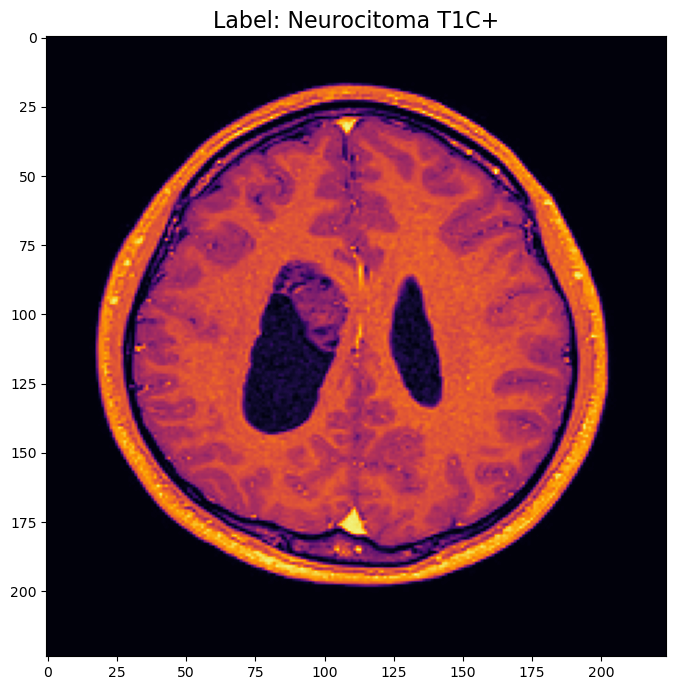

In [24]:
# Select random sample from train_df
idx = random.sample(dataset_df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(dataset_df.image_path[idx]), dataset_df.label[idx]

# View the random sample
view_sample(sample_image, sample_label, color_map='inferno')

<a id=1.5></a>
### View Multiple Randomly Selected Samples

In [ ]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='gray', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    idx = random.sample(df.index.to_list(), count)    
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}')
        plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map);
    
    return

view_mulitiple_samples(dataset_df, _load, 
                       count=30, color_map='jet', 
                       fig_size=(20, 24))

<a id='1.6'></a>
### View Train Labels Distribution

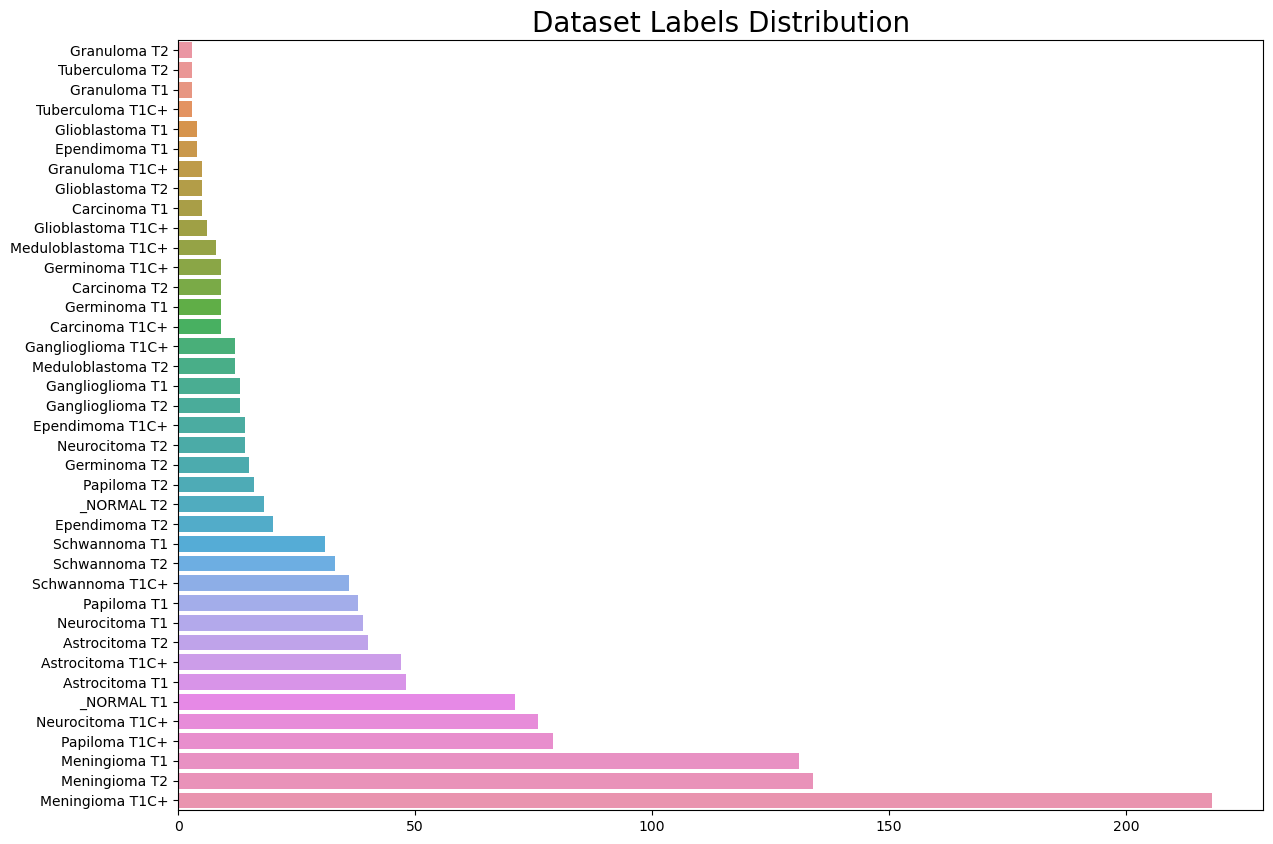

In [25]:
# Generate Figure
fig = plt.figure(figsize=(14, 10))

# Plot Labels Distribution
plt.title('Dataset Labels Distribution', fontsize=20)
distribution = dataset_df['label'].value_counts().sort_values()
sns.barplot(x=distribution.values,
            y=list(distribution.keys()),
            orient="h");

<div class="alert alert-block alert-info">
    <h3>Observe</h3>
    We observe that the dataset labels are severly imbalanced. However, this may be representative of the characteristics of brain tumors as some types may be more common than others.
</div>

<a id=1.7></a>
### Discard Insufficient Sample Classes

In [26]:
# Get insufficient labels
insufficient_labels = list(distribution[distribution.values < 10].keys())

# Get insufficient labels indices from df
insufficient_indices = pd.concat([dataset_df[dataset_df.label == _] for _ in insufficient_labels]).index

# Remove insufficient labels
dataset_df = dataset_df.drop(insufficient_indices).reset_index(drop=True)

In [27]:
dataset_df['label'].value_counts().sort_values()

Ganglioglioma T1C+     12
Meduloblastoma T2      12
Ganglioglioma T2       13
Ganglioglioma T1       13
Neurocitoma T2         14
Ependimoma T1C+        14
Germinoma T2           15
Papiloma T2            16
_NORMAL T2             18
Ependimoma T2          20
Schwannoma T1          31
Schwannoma T2          33
Schwannoma T1C+        36
Papiloma T1            38
Neurocitoma T1         39
Astrocitoma T2         40
Astrocitoma T1C+       47
Astrocitoma T1         48
_NORMAL T1             71
Neurocitoma T1C+       76
Papiloma T1C+          79
Meningioma T1         131
Meningioma T2         134
Meningioma T1C+       218
Name: label, dtype: int64

<div class="alert alert-block alert-warning">
    <h3>⚠️Warning</h3>
    By removing insufficient samples from the minority classes we discard the useful data which not only limits the number of tumor types we can classify, but also the structural information in the images which might prove to useful for learning other patterns in the data. The recommended method for dealing with the minority classes would be to gather more data!
</div>

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#B6EADA;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='2'></a>
# 2 | Data Preprocessing: Building An Input Data Pipeline
<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/T1D2yGny/167.jpg); background-size: 100% auto;"></div>

<br>  

In order to train models with this dataset we'll build an input data pipeline using TensorFlow's tf.data API to handle the loading and passing of the image data to the model. 

To achieve a faster training time we'll insure that the training data is batched and prefetched while the model is training on a previously passed sample. 

> For more information on the tf.data API, follow this link: [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

Since ImageDataGenerators aren't used in this notebook, an image data augmentation layer will have to be constructed manually. 

> For more information on ImageDataGenerators, follow these links: 
> 
> - [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
> - [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)

### Re-label the encoded classes

In [28]:
# Generate Label Encoder
label_encoder = LabelEncoder()

# Label Encode the Image Labels
dataset_df['label_encoded'] = label_encoder.fit_transform(dataset_df.label)

# View first 10 samples
dataset_df.head(10)

,image_path,label,label_encoded
0,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1C+,11
1,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma T2,8
2,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T1C+,17
3,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1,0
4,/kaggle/input/brain-tumor-mri-images-44c/Epend...,Ependimoma T2,4
5,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1C+,11
6,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1C+,11
7,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1C+,11
8,/kaggle/input/brain-tumor-mri-images-44c/Gangl...,Ganglioglioma T1,5
9,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T1C+,17


In [29]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 24
Classes: ['Astrocitoma T1' 'Astrocitoma T1C+' 'Astrocitoma T2' 'Ependimoma T1C+'
 'Ependimoma T2' 'Ganglioglioma T1' 'Ganglioglioma T1C+'
 'Ganglioglioma T2' 'Germinoma T2' 'Meduloblastoma T2' 'Meningioma T1'
 'Meningioma T1C+' 'Meningioma T2' 'Neurocitoma T1' 'Neurocitoma T1C+'
 'Neurocitoma T2' 'Papiloma T1' 'Papiloma T1C+' 'Papiloma T2'
 'Schwannoma T1' 'Schwannoma T1C+' 'Schwannoma T2' '_NORMAL T1'
 '_NORMAL T2']


<a id='2.1'></a>
### Create Train & Test Splits

In [33]:
# Create Train/Test split with Training Set
train_split_idx, val_test_split_idx, _, _ = train_test_split(dataset_df.index, 
                                                        dataset_df.label_encoded, 
                                                        test_size=0.4,
                                                        stratify=dataset_df.label_encoded,
                                                        random_state=CFG.SEED)

In [34]:
# Get training and validation data
train_df = dataset_df.iloc[train_split_idx].reset_index(drop=True)
val_test_df = dataset_df.iloc[val_test_split_idx].reset_index(drop=True)

# View shapes
train_df.shape, val_test_df.shape

((700, 3), (468, 3))

### Create Validation & Test Splits

In [35]:
# Create Train/Test split with Training Set
val_split_idx, test_split_idx, _, _ = train_test_split(val_test_df.index, 
                                                       val_test_df.label_encoded, 
                                                       test_size=0.6,
                                                       stratify=val_test_df.label_encoded,
                                                       random_state=CFG.SEED)

In [36]:
# Get validation and test data
val_df = dataset_df.iloc[val_split_idx].reset_index(drop=True)
test_df = dataset_df.iloc[test_split_idx].reset_index(drop=True)

# View shapes
val_df.shape, test_df.shape

((187, 3), (281, 3))

In [37]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

# View the counts
print(f'train samples count:\t\t{train_size}')
print(f'validation samples count:\t{val_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		700
validation samples count:	187
test samples count:		281
TOTAL:				1168


<a id='2.2'></a>
### View New Train & Validation Labels Distribution

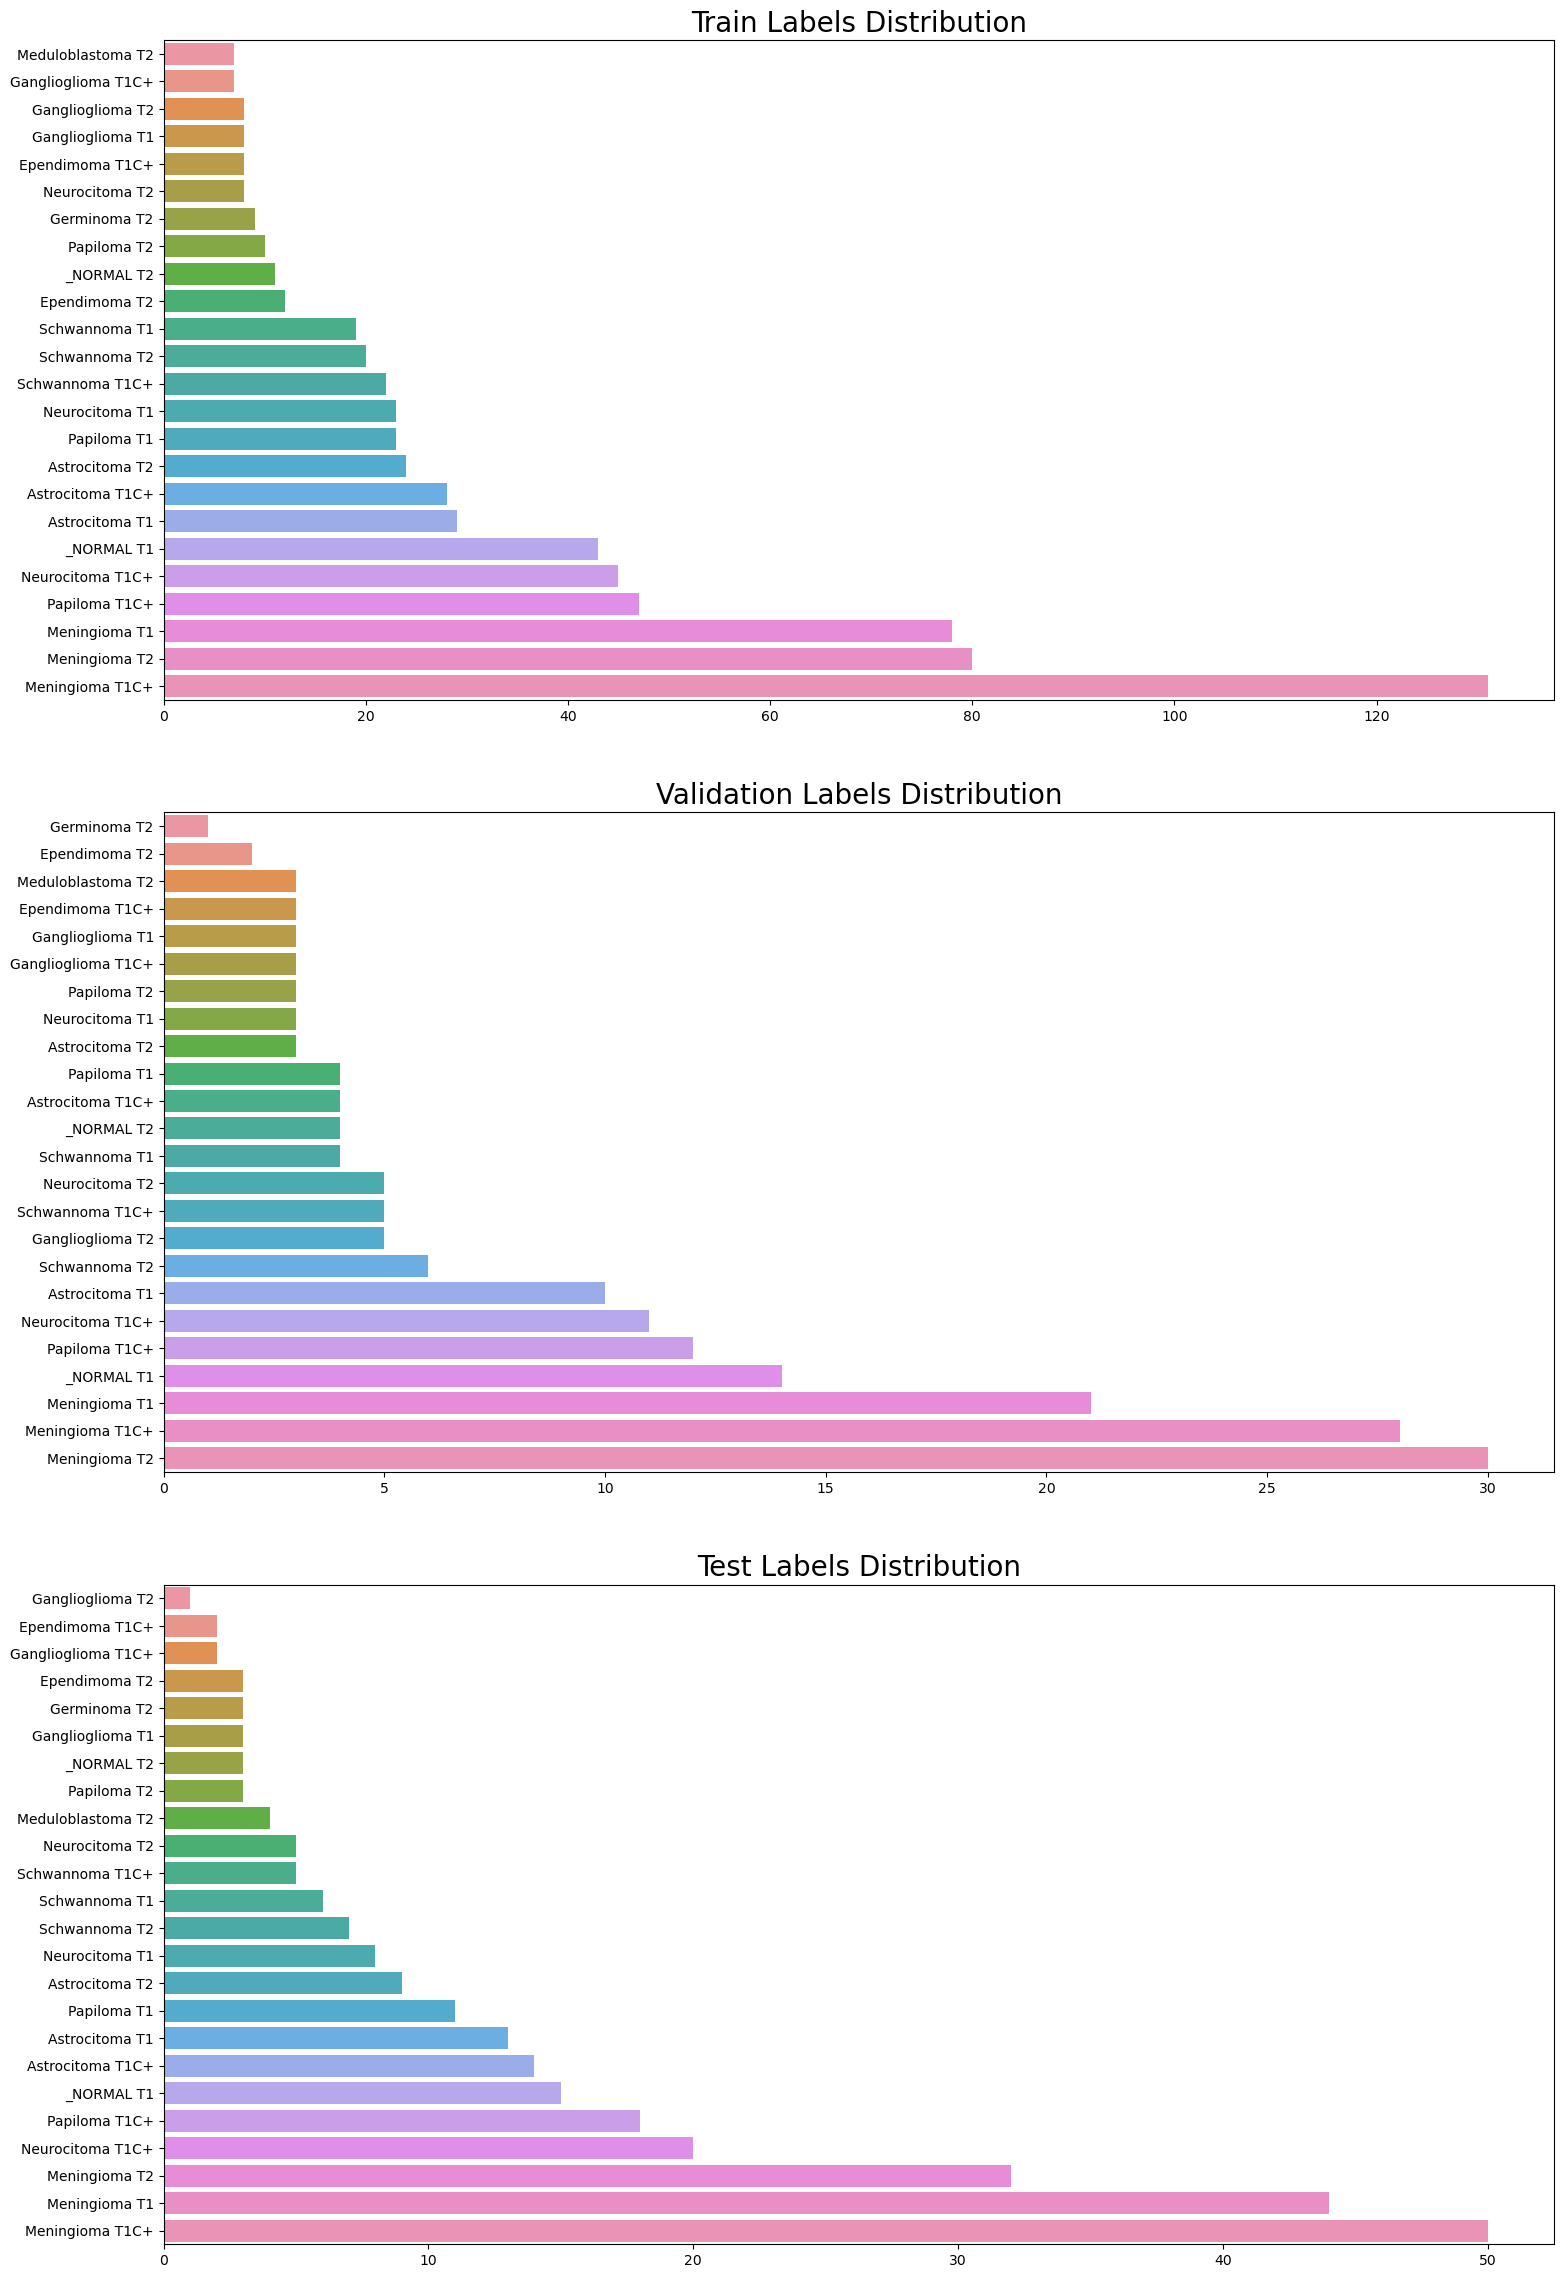

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 24))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1);

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=20)
val_distribution = val_df['label'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2);

# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax3);

<a id='2.3'></a>
### Create an Image Data Augmentation Layer

In [39]:
# Build augmentation layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
], name='augmentation_layer')

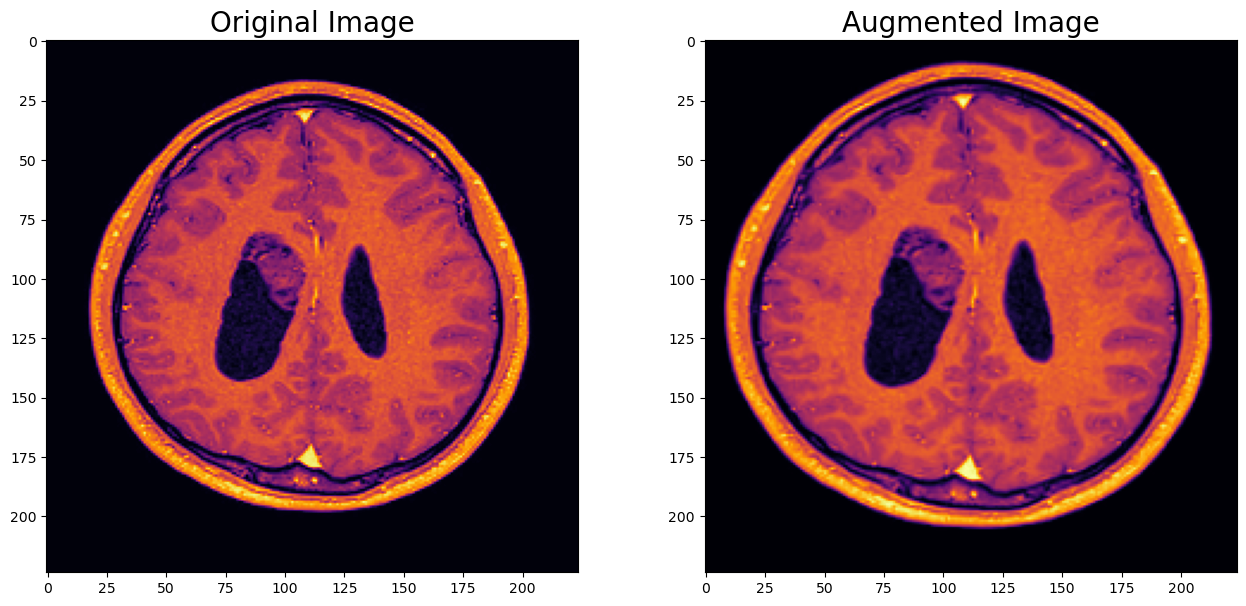

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(tf.image.rgb_to_grayscale(sample_image), cmap='inferno');

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(tf.image.rgb_to_grayscale(augmentation_layer(sample_image)), cmap='inferno');

<div class="alert alert-block alert-info">
    <h3>Observe</h3>
    The augmentation layer generates augmentations that are slightly different to the original images. This is intended as we aim to generate augmented images which are similar to that of the original dataset images while preserving the images key features. 
</div>

<a id='2.4'></a>
### Create Input Data Pipeline w. tf.data API

In [41]:
def encode_labels(labels, encode_depth=24):
    return tf.one_hot(labels, depth=encode_depth).numpy()

def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    '''
    Generates an input pipeline using the tf.data API given a Pandas DataFrame and image loading function.
    
    @params
        - df: (pd.DataFrame) -> DataFrame containing paths and labels 
        - load_function: (function) -> function used to load images given their paths
        - augment: (bool) -> condition for applying augmentation
        - batch_size: (int) -> size for batched (default=32) 
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (str) -> cache path for caching data, data is not cached when None (default=None)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)
        
    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    # Get image paths and labels from DataFrame
    image_paths = df.image_path
    image_labels = encode_labels(df.label_encoded)
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    
    # Map augmentation layer and load function to dataset inputs if augment is True
    # Else map only the load function
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)
    
    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # Apply batching
    ds = ds.batch(batch_size)
    
    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)
    
    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    # Return the dataset
    return ds

In [42]:
# Generate Train Input Pipeline
train_ds = create_pipeline(train_df, _load, augment=True, 
                           batch_size=CFG.BATCH_SIZE, 
                           shuffle=False, prefetch=True)

# Generate Validation Input Pipeline
val_ds = create_pipeline(val_df, _load, 
                         batch_size=CFG.BATCH_SIZE, 
                         shuffle=False, prefetch=False)

# Generate Test Input Pipeline
test_ds = create_pipeline(test_df, _load, 
                          batch_size=CFG.BATCH_SIZE, 
                          shuffle=False, prefetch=False)

In [43]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24), dtype=tf.float32, name=None))>
Test Input Data Pipeline:

 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24), dtype=tf.float32, name=None))>


<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#B6EADA;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>
           
<a id="3"></a>
# 3 | Transfer Learning Model: EfficientNet V2 B0
<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/T1D2yGny/167.jpg); background-size: 100% auto;"></div>

<br>  

EfficientNetV2 is a convolutional neural network that has faster training speed and better parameter efficiency than previous EfficientNetV1 models. To develop these models, the authors use a combination of training-aware neural architecture search and scaling, to jointly optimize training speed. The models were searched from the search space enriched with new ops such as Fused-MBConv.

<center>
    <figure>
        <img src="https://i.postimg.cc/vBSTR3V0/59864ee4.png" alt ="MBConv and Fused-MBConv" style='width: 400px;'>
        <figcaption>
            Image Source: <a href="https://wandb.ai/wandb_fc/pytorch-image-models/reports/EfficientNetV2--Vmlldzo2NTkwNTQ">[Source]</a></figcaption>
    </figure>
</center>

**For more information follow the links below:**
> - EfficientNet V2 Paper (2021): [EfficientNetV2: Smaller Models and Faster Training](https://arxiv.org/pdf/2104.00298v2.pdf)
> - [EfficientNet: Improving Accuracy and Efficiency through AutoML and Model Scaling](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html)
> - [Wandb: EfficientNetV2](https://wandb.ai/wandb_fc/pytorch-image-models/reports/EfficientNetV2--Vmlldzo2NTkwNTQ)

<a id="tfhub"></a>
## TensorFlow Hub

TensorFlow Hub is a repository of trained machine learning models ready for fine-tuning and deployable anywhere. Reuse trained models like BERT and Faster R-CNN with just a few lines of code.

In this section we'll be using pre-trained models from TensorFlow Hub. 

> For more information on TensorFlow Hub or if you would like to access the same models in PyTorch/JAX, check out the following links:
> - [TensorFlow Hub](https://www.tensorflow.org/hub)
> - [HuggingFace🤗](https://huggingface.co/)

In [44]:
# Here's a function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

<a id="3.1"></a>
### Get EfficientNet From TensorFlow Hub

In [45]:
# Get EfficientNet V2 B0 here
efficientnet_v2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2'
model_name = 'efficientnet_v2_b0'

# Set trainable to False for inference-only 
set_trainable=False

efficientnet_v2_b0 = get_tfhub_model(efficientnet_v2_url, 
                                     model_name, 
                                     model_trainable=set_trainable)

<a id="3.2"></a>
### Define EfficientNet Model

In [47]:
def efficientnet_v2_model():
    
    initializer = tf.keras.initializers.GlorotNormal(seed=CFG.SEED)
    
    efficientnet_v2_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        efficientnet_v2_b0,
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu', kernel_initializer=initializer),
        layers.Dense(256, activation='relu', kernel_initializer=initializer),
        layers.Dense(24, dtype=tf.float32, activation='softmax', kernel_initializer=initializer)
    ], name='efficientnet_v2_sequential_model')
    
    return efficientnet_v2_sequential

In [48]:
# Generate Model
model_efficientnet_v2 = efficientnet_v2_model()

# Generate Summary of the Model
model_efficientnet_v2.summary()

Model: "efficientnet_v2_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_v2_b0 (KerasLa  (None, 1280)             5919312   
 yer)                                                            
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 24)                6168      
                                                                 
Total params: 6,712,680
Trainable params: 793,368
Non-trainable params: 5,919,312
__________________

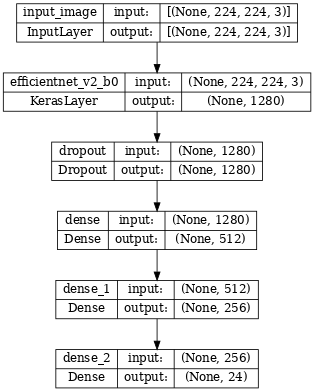

In [49]:
# Explore model visually
plot_model(
    model_efficientnet_v2, dpi=60,
    show_shapes=True
)

<a id="3.3"></a>
### Train EfficientNet Model

To train this model we'll use Categorical Crossentropy as the loss function since this notebook approaches the problem at hand as a classification problem for multiple labels. As for the optimizer, we'll use the Adam optimizer with 0.001 as the (default) learning rate. 

To prevent the occurance of overfitting during training we'll have to make use of TensorFlow's Callback API to implement the EarlyStopping & ReduceLROnPlateau callbacks. The only metrics we'll track during the training of the model will be the loss and accuracy metrics.

**See the following for more information:**
>- **Categorical Crossentropy Loss Function:**
>    - [Understanding Categorical Cross-Entropy Loss, Binary Cross-Entropy Loss, Softmax Loss, Logistic Loss, Focal Loss and all those confusing names](https://gombru.github.io/2018/05/23/cross_entropy_loss/)
>    - [TensorFlow Categorical Crossentropy Loss Implementation](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)
>- **Adam Optimizer:**
>    - [Academic Paper | Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)
>    - [TensorFlow Adam Implementation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
>- **TensorFlow Callback API:**
>    - [EarlyStopping Implementation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
>    - [ReduceLROnPlateau Implementation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau)
>- **TensorFlow Metrics:**
>    - [TensorFlow Metrics Overview](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [50]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data. 
        
        @params
        - model: (tf.keras.model) -> model to be trained 
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on 
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        
        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''
    
    model_history = {}
    
    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
        
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [51]:
# Define Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True)

# Define Reduce Learning Rate Callback
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

# Define Callbacks and Metrics lists
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

In [52]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_efficientnet_v2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model 
print(f'Training {model_efficientnet_v2.name}.')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

efficientnet_v2_history = train_model(
    model_efficientnet_v2, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)

Training efficientnet_v2_sequential_model.
Train on 700 samples, validate on 187 samples.
----------------------------------
Epoch 1/20
22/22 [==============================] - 16s 216ms/step - loss: 2.2976 - accuracy: 0.4186 - val_loss: 1.4312 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 2/20
22/22 [==============================] - 3s 157ms/step - loss: 1.1911 - accuracy: 0.6629 - val_loss: 1.1146 - val_accuracy: 0.6417 - lr: 0.0010
Epoch 3/20
22/22 [==============================] - 3s 157ms/step - loss: 0.8405 - accuracy: 0.7529 - val_loss: 0.8719 - val_accuracy: 0.7219 - lr: 0.0010
Epoch 4/20
22/22 [==============================] - 3s 152ms/step - loss: 0.6393 - accuracy: 0.8086 - val_loss: 0.9335 - val_accuracy: 0.7166 - lr: 0.0010
Epoch 5/20
22/22 [==============================] - 3s 156ms/step - loss: 0.5288 - accuracy: 0.8357 - val_loss: 0.6941 - val_accuracy: 0.7914 - lr: 0.0010
Epoch 6/20
22/22 [==============================] - 3s 156ms/step - loss: 0.4588 - accuracy: 0.8557

In [53]:
# Evaluate the model
efficientnet_v2_evaluation = model_efficientnet_v2.evaluate(test_ds)

9/9 [==============================] - 1s 88ms/step - loss: 0.3494 - accuracy: 0.9075


In [54]:
# Generate model probabilities and associated predictions
efficientnet_v2_test_probabilities = model_efficientnet_v2.predict(test_ds, verbose=1)
efficientnet_v2_test_predictions = tf.argmax(efficientnet_v2_test_probabilities, axis=1)

9/9 [==============================] - 1s 67ms/step


<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#B6EADA;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='4'></a>
# 4 | Transfer Learning Model: Vision Transformer
<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/T1D2yGny/167.jpg); background-size: 100% auto;"></div>

<br>              

The Vision Transformer (ViT) model was introduced in a conference research paper titled "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale," published at The International Conference on Learning Representations (ICLR) in 2021. ViTs are used in image recognition tasks such as object detection, image segementation, action recognition and image classification. 

ViTs are based off transformer architectures used in Natural Language Processing (NLP) which converts texts into sequence tokens and generates text embeddings. However, with ViTs an input image is preprocessed into patches which are reminiscent of word tokens for NPL transformers. These 'patches' are used along with the transform encoder to generate image embeddings. The transformer encoder blocks consists of three components, namely:
1. **Layer Normalization:** Applied to the patches and attention for computational speedup.
2. **Multi-head Attention:** Used to generate and concatenate attention heads for all patches to capture local and global dependencies in an image. 
3. **Multi-Layer Perceptrons (MLP):** Takes the attention heads and passes them through two dense layers with the Gaussian Error Linear Unit (GELU) as the activation function.

<center>
    <figure>
        <img src="https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F9c096bed-e908-49da-a716-f8a78de952a3_1358x892.png" alt ="Vision Transformer" style='width:60%;'>
        <figcaption>
            Image Source: <a href="https://cameronrwolfe.substack.com/p/vision-transformers">[Source]</a></figcaption>
    </figure>
</center>
In comparison to traditional Convolution Neural Network (CNN) Architechtures, Vision Transformers achive remarkable results while requiring less computational resources for pre-training. However, Vision Transformers exhibits weaker inductive bias which leads to an increased reliance on regularization techniques and data augmentation for smaller datasets. For this reason, CNNs generally perform better on smaller datasets while Vision Transformers excel on large datasets.

So for this section we will use the pre-trained ViT-B16 model.

**For more information see the following:**
> - Vision Transformer Paper: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (2021)](https://arxiv.org/pdf/2010.11929.pdf)
> - Attention Mechanism Paper: [Attention Is All You Need (2017)](https://arxiv.org/pdf/1706.03762.pdf)
> - V7Labs Article: [Vision Transformer: What It Is & How It Works [2023 Guide]](https://www.v7labs.com/blog/vision-transformer-guide)
> - Viso.ai Article: [Vision Transformers (ViT) in Image Recognition – 2022 Guide](https://viso.ai/deep-learning/vision-transformer-vit/)

In [55]:
!pip install -q vit-keras

<a id='4.1'></a>
### Get Vision Transformer Model

In [56]:
from vit_keras import vit

# Download the model
vit_model = vit.vit_b16(
        image_size=224,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=2)

# Freeze model layers for inference-mode only
for layer in vit_model.layers:
    layer.trainable = False

347502902/347502902 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


<a id='4.2'></a>
### Define Vision Transformer Model

In [57]:
def vit_b16_model():
    
    initializer = tf.keras.initializers.GlorotNormal(seed=CFG.SEED)
    
    vit_b16_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        vit_model,
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu', kernel_initializer=initializer),
        layers.Dense(256, activation='relu', kernel_initializer=initializer),
        layers.Dense(24, dtype=tf.float32, activation='softmax', kernel_initializer=initializer)
    ], name='vit_b16_sequential_model')
    
    return vit_b16_sequential

In [58]:
# Generate Model
model_vit_b16 = vit_b16_model()

# Generate Summary of the Model
model_vit_b16.summary()

Model: "vit_b16_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               393728    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 24)                6168      
                                                                 
Total params: 86,329,880
Trainable params: 531,224
Non-trainable params: 85,798,656
_________________________________________________________________


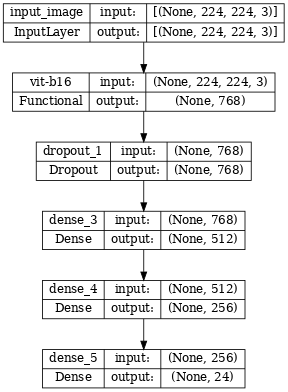

In [59]:
# Explore model visually
plot_model(
    model_vit_b16, dpi=60,
    show_shapes=True
)

<a id='4.3'></a>
### Train Vision Transformer Model

In [60]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_vit_b16.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model 
print(f'Training {model_vit_b16.name}.')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

vit_b16_history = train_model(
    model_vit_b16, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)

Training vit_b16_sequential_model.
Train on 700 samples, validate on 187 samples.
----------------------------------
Epoch 1/20
22/22 [==============================] - 26s 529ms/step - loss: 2.3660 - accuracy: 0.3457 - val_loss: 1.6442 - val_accuracy: 0.5348 - lr: 0.0010
Epoch 2/20
22/22 [==============================] - 8s 362ms/step - loss: 1.4026 - accuracy: 0.6000 - val_loss: 1.2367 - val_accuracy: 0.5882 - lr: 0.0010
Epoch 3/20
22/22 [==============================] - 8s 360ms/step - loss: 1.0388 - accuracy: 0.7029 - val_loss: 1.0489 - val_accuracy: 0.6791 - lr: 0.0010
Epoch 4/20
22/22 [==============================] - 8s 363ms/step - loss: 0.8627 - accuracy: 0.7286 - val_loss: 1.0489 - val_accuracy: 0.6738 - lr: 0.0010
Epoch 5/20
22/22 [==============================] - 8s 362ms/step - loss: 0.7270 - accuracy: 0.7629 - val_loss: 0.8669 - val_accuracy: 0.7326 - lr: 0.0010
Epoch 6/20
22/22 [==============================] - 8s 351ms/step - loss: 0.6717 - accuracy: 0.7786 - val_l

In [61]:
# Evaluate the model
vit_b16_evaluation = model_vit_b16.evaluate(test_ds)

9/9 [==============================] - 2s 250ms/step - loss: 0.5062 - accuracy: 0.8612


In [62]:
# Generate model probabilities and associated predictions
vit_b16_test_probabilities = model_vit_b16.predict(test_ds, verbose=1)
vit_b16_test_predictions = tf.argmax(vit_b16_test_probabilities, axis=1)

9/9 [==============================] - 5s 251ms/step


<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#B6EADA;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>
           
<a id=5></a>
# 5 | Ensemble via Averaging
<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/T1D2yGny/167.jpg); background-size: 100% auto;"></div>

<br>

<a id=5.1></a>
### 🤔 What is ensembling via averaging?

**According to [ChatGPT](https://openai.com/blog/chatgpt/):**

> Ensembling via averaging is a type of ensemble method used in machine learning to improve the accuracy and stability of a predictive model by combining the predictions of multiple base models.
>
> In this approach, each base model is trained on the same dataset but with different hyperparameters, algorithms, or subsets of features, in order to capture different aspects of the data and reduce the risk of overfitting. Once the base models are trained, their predictions are combined into a single prediction using some averaging technique, such as simple averaging, weighted averaging, or geometric mean.
>
> Simple averaging involves taking the average of the predictions of all base models, without considering their individual performance or importance. Weighted averaging, on the other hand, assigns a weight to each base model's prediction based on its performance on a validation set or other criteria. The weights are typically learned using techniques such as cross-validation or grid search. Geometric mean averaging computes the geometric mean of the predictions of all base models, which can be useful when dealing with positive-valued data or when there are extreme values or outliers.


**For this notebook, we'll only focus on ensembling via averaging since other ensembling methods will introduce another layer of complexity to this notebook's contents.**

<a id=5.2></a>
### Simple Average Ensembling

Given a data set ${\displaystyle X=\{x_{1},\ldots ,x_{n}\}}$, the arithmetic mean (also mean or simple average), denoted ${\bar {x}}$ (read x bar), is the mean of the $n$ values $x_{1},\ldots ,x_{n}$. Simple Averaging is defined by the formula:

<center>$\displaystyle {\bar {x}}={\frac {1}{n}}\left(\sum _{i=1}^{n}{x_{i}}\right)={\frac {x_{1}+x_{2}+\dots +x_{n}}{n}}$</center>

**According to [ChatGPT](https://openai.com/blog/chatgpt/):**

> Simple average ensembling is a type of ensemble method used in machine learning to combine the predictions of multiple base models by taking the arithmetic mean of their predictions.
>
> In this approach, each base model is trained on the same dataset but with different hyperparameters, algorithms, or subsets of features, in order to capture different aspects of the data and reduce the risk of overfitting. Once the base models are trained, their predictions are combined into a single prediction using the arithmetic mean.
> 
> The arithmetic mean is calculated by adding together the predictions of each base model and then dividing by the number of models. Simple average ensembling tends to be a straightforward and effective way to combine the predictions of multiple models, especially when the individual models have similar performance and reliability.
>
> Simple average ensembling can be applied to a wide range of machine learning tasks and algorithms, including regression, classification, and clustering, among others. It can also be combined with other ensemble techniques, such as weighted averaging, or bagging, to further improve the performance and accuracy of the model.
>
> Overall, simple average ensembling is a useful tool in ensemble learning that can help to improve the accuracy and robustness of the model, by reducing the variance and bias of the predictions, and by capturing a broader range of patterns and relationships in the data.

**For more information see the following:**
> - [Medium | Simple Weighted Average Ensemble | Machine Learning](https://medium.com/analytics-vidhya/simple-weighted-average-ensemble-machine-learning-777824852426)
> - [Wikipedia | Arithmetic Mean](https://en.wikipedia.org/wiki/Arithmetic_mean)

In [63]:
# Compute average probabilities
avg_probabilities = np.mean([
    efficientnet_v2_test_probabilities, 
    vit_b16_test_probabilities], axis=0)

# Compute average ensemble predictions
avg_predictions = tf.argmax(avg_probabilities, axis=1)

<a id=5.3></a>
### Weighted Average Ensembling

The weighted average of a non-empty finite tuple of data ${\displaystyle \left(x_{1},x_{2},\dots ,x_{n}\right)}$, with corresponding non-negative weights ${\displaystyle \left(w_{1},w_{2},\dots ,w_{n}\right)}$ is defined as:
<center>${\displaystyle {\bar {x}}={\frac {\sum \limits _{i=1}^{n}w_{i}x_{i}}{\sum \limits _{i=1}^{n}w_{i}}}}$</center>

which expands to:
<center>${\displaystyle {\bar {x}}={\frac {w_{1}x_{1}+w_{2}x_{2}+\cdots +w_{n}x_{n}}{w_{1}+w_{2}+\cdots +w_{n}}}.}$</center>

<br>

Note that the weights cannot be negative. However, some weights may be zero, but not all since this would result in division by zero. When the weights are normalized, meaning:
<center>${\displaystyle {\displaystyle w_{i}'={\frac {w_{i}}{\sum \limits _{j=1}^{n}{w_{j}}}}} \qquad \& \qquad {\sum \limits _{i=1}^{n}{w_{i}'}=1}}$</center>

then the weighted average can be expressed as a linear combination of the normalized weights and samples:
<center>${\displaystyle {\bar {x}}=\sum \limits _{i=1}^{n}{w_{i}'x_{i}}}$</center>

**According to [ChatGPT](https://openai.com/blog/chatgpt/):**
> Weighted ensembling is a type of model averaging ensembling, which is a category of ensemble methods that involves combining the predictions of multiple models to improve prediction accuracy.
>
> In weighted ensembling, each model's prediction is weighted by a certain factor or weight, which reflects the relative importance or performance of the model. The weights assigned to each model's prediction can be determined using a variety of techniques, such as cross-validation, grid search, or meta-learning.
>
> Weighted ensembling is a flexible and powerful technique that can combine the strengths of different models and mitigate their weaknesses, leading to improved prediction accuracy and robustness. It can be applied to a wide range of machine learning tasks and algorithms, including regression, classification, and clustering, among others.

**For more information see the following:**
> - [Machine Learning Mastery | How to Develop a Weighted Average Ensemble With Python](https://machinelearningmastery.com/weighted-average-ensemble-with-python/#:~:text=Weighted%20average%20or%20weighted%20sum%20ensemble%20is%20an%20ensemble%20machine,related%20to%20the%20voting%20ensemble.)
> - [Wikipedia | Weighted Arithmetic Mean](https://en.wikipedia.org/wiki/Weighted_arithmetic_mean)

In [64]:
# Define weights and list model probabilities
weights = [0.6, 0.4]
model_probabilities = [efficientnet_v2_test_probabilities, vit_b16_test_probabilities]

# Compute weighted average probabilities
weighted_avg_probabilities = sum([w * p for w, p in zip(weights, model_probabilities)])

# Compute weighted average ensemble predictions
weighted_avg_predictions = tf.argmax(weighted_avg_probabilities, axis=1)

<a id=5.4></a>
### Geometric Mean Ensembling

The geometric mean is a mean or average which indicates a central tendency of a finite set of positive real numbers by using the product of their values (as opposed to the arithmetic mean which uses their sum). The geometric mean is defined as the nth root of the product of n numbers, i.e., for a set of numbers a1, a2, ..., an, the geometric mean is defined as:

<center>$\displaystyle \left(\prod _{i=1}^{n}x_{i}\right)^{\frac {1}{n}}={\sqrt[{n}]{x_{1}x_{2}\cdots x_{n}}}$</center>

<br>

We can also express the geometrics mean as the logscaled arithmetic mean:
<center>$\displaystyle \left(\prod _{i=1}^{n}x_{i}\right)^{\frac {1}{n}}={\exp\bigg(\frac {1}{n}}\sum _{i=1}^{n}\ln{a_{i}\bigg)}$</center>

**According to [ChatGPT](https://openai.com/blog/chatgpt/):**
> Geometric mean ensembling is a type of ensemble method used in machine learning to combine the predictions of multiple base models by taking the geometric mean of their predictions.
>
> In this approach, each base model is trained on the same dataset but with different hyperparameters, algorithms, or subsets of features, in order to capture different aspects of the data and reduce the risk of overfitting. Once the base models are trained, their predictions are combined into a single prediction using the geometric mean.
>
> The geometric mean is calculated by multiplying together the predictions of each base model and then taking the nth root of the product, where n is the number of models. The geometric mean tends to reduce the impact of extreme values or outliers in the predictions, which can help to improve the stability and robustness of the ensemble model.
> 
> Geometric mean ensembling can be applied to a wide range of machine learning tasks and algorithms, including regression, classification, and clustering, among others. It can also be combined with other ensemble techniques, such as simple averaging, weighted averaging, or bagging, to further improve the performance and accuracy of the model.
>
> Overall, geometric mean ensembling is a powerful tool in ensemble learning that can help to capture a broader range of patterns and relationships in the data, reduce the variance and bias of the predictions, and improve the overall accuracy and robustness of the model.

**For more information see the following:**
> - [Machine Learning Mastery | Arithmetic, Geometric, and Harmonic Means for Machine Learning](https://machinelearningmastery.com/arithmetic-geometric-and-harmonic-means-for-machine-learning/)
> - [Wikipedia | Geometric Mean](https://en.wikipedia.org/wiki/Geometric_mean)

In [65]:
# List model probabilities
model_probabilities = [efficientnet_v2_test_probabilities, vit_b16_test_probabilities]

# Compute geometric mean probabilities
geometric_mean_probabilities = np.power(np.multiply(model_probabilities[0], 
                                                    model_probabilities[1]), 
                                        1/len(model_probabilities))

# Compute weighted average ensemble predictions
geometric_mean_predictions = tf.argmax(geometric_mean_probabilities, axis=1)

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#B6EADA;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='6'></a>
# 6 | Performance Evaluation
<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/T1D2yGny/167.jpg); background-size: 100% auto;"></div>

<br>  

Now that the model has trained on the data we need to inspect how well it performs on the unseen test data. In order to conduct this inspection we need to evaluate the performance of the model on the test data and record evaluation metrics. Since this is a categorical classification problem we'll make use of some well known classification metrics. Hence, we'll make use of the Scikit Learn library to inspect the model. We'll also use the following to inspect the model:

> - [Classification Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report)
> - [Accuracy Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
> - [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
> - [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)
> - [F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) 
> - [Matthews Correlation Coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)

<a id='6.1'></a>
### Plot Model Histories 

In [67]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

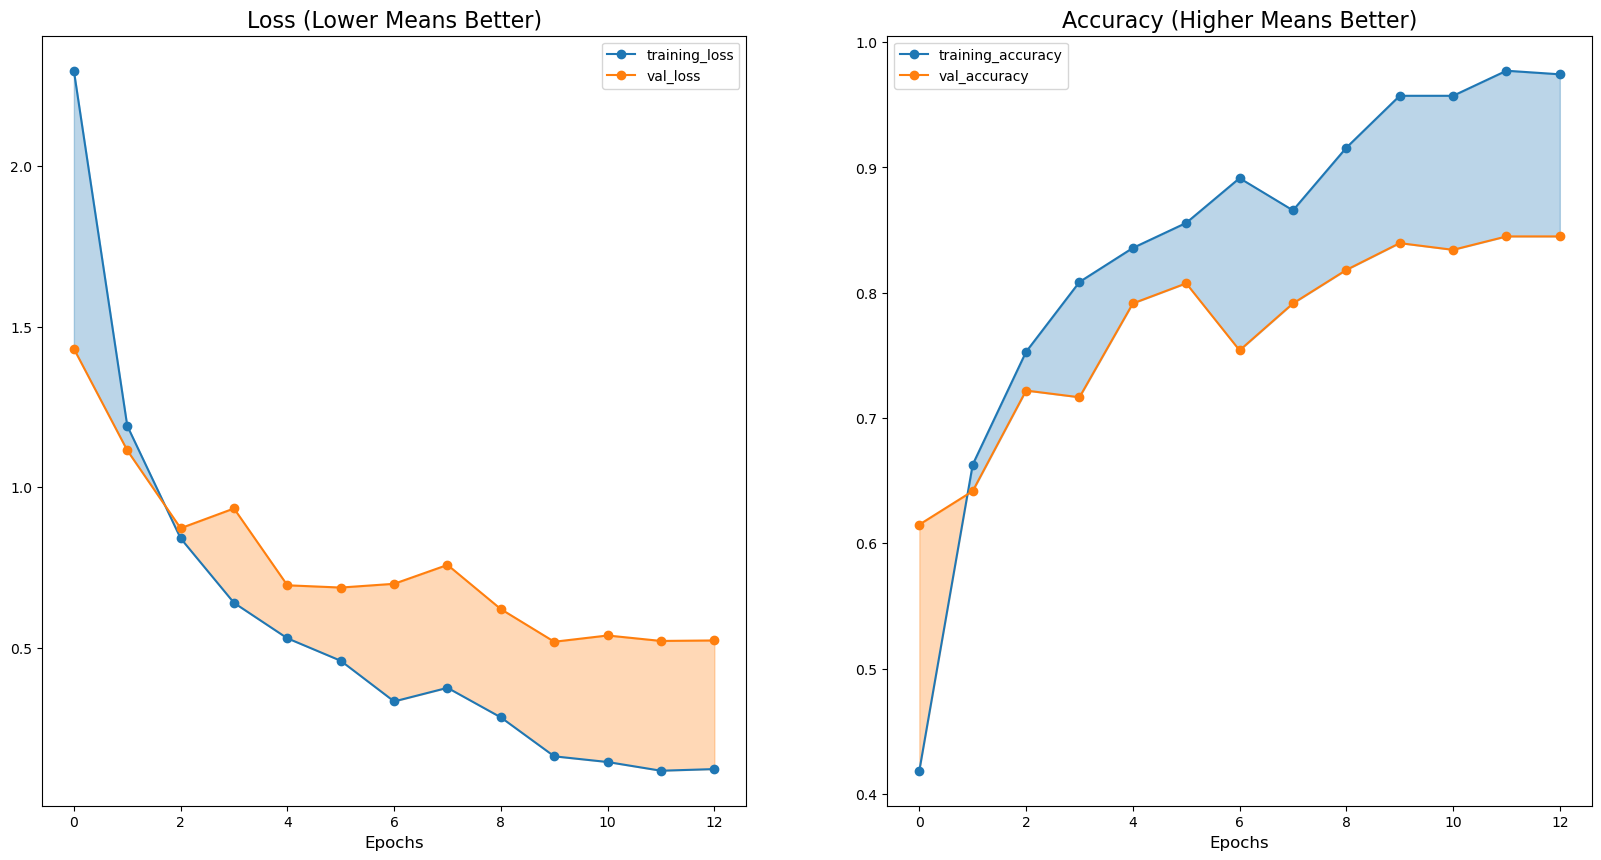

In [68]:
# Plot EfficientNet V2 B0 model training history 
plot_training_curves(efficientnet_v2_history)

<div class="alert alert-block alert-info">
    <h3>Observe</h3>
    We observe that the model was able to converge to a training loss which is lower than the validation loss. However, no overfitting occured during the training of the model. We should also note that the validation loss convergence was slightly unstable.
</div>

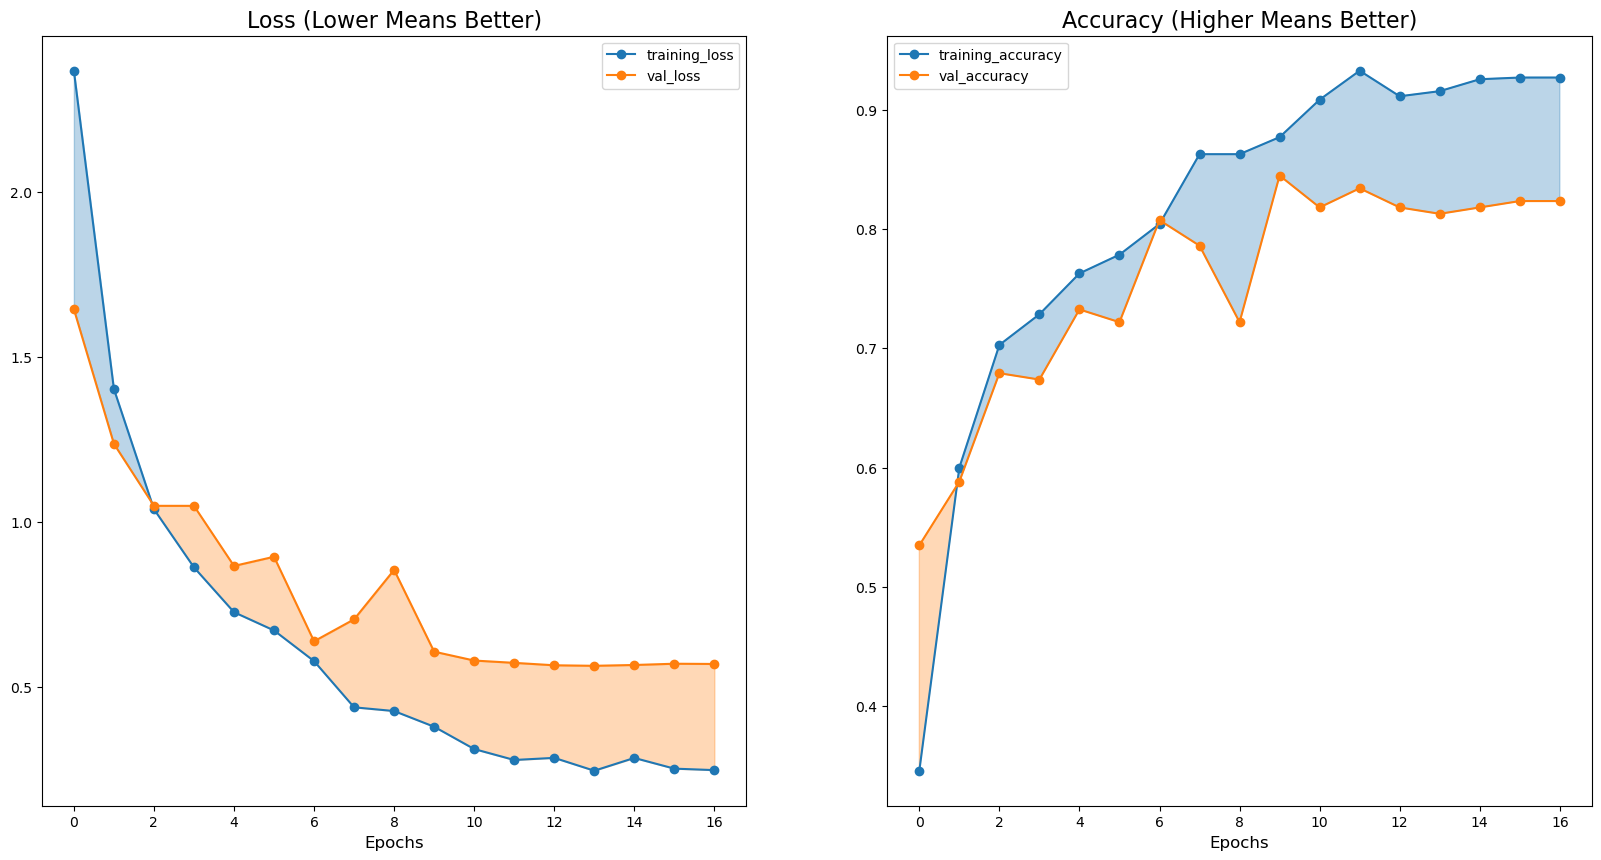

In [69]:
# Plot VIT B16 model training history 
plot_training_curves(vit_b16_history)

<div class="alert alert-block alert-info">
    <h3>Observe</h3>
    We observe that the model was able to converge to a training loss which is lower than the validation loss, which is the same case with the EfficientNet model. However, no overfitting occured during the training of the model and (similar to the EfficientNet model) we should also note that the validation loss convergence was slightly unstable.
</div>

<a id='6.2'></a>
### Plot Confusion Matrix

In [70]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    
    return

### EfficientNet V2 B0 Confusion Matrix

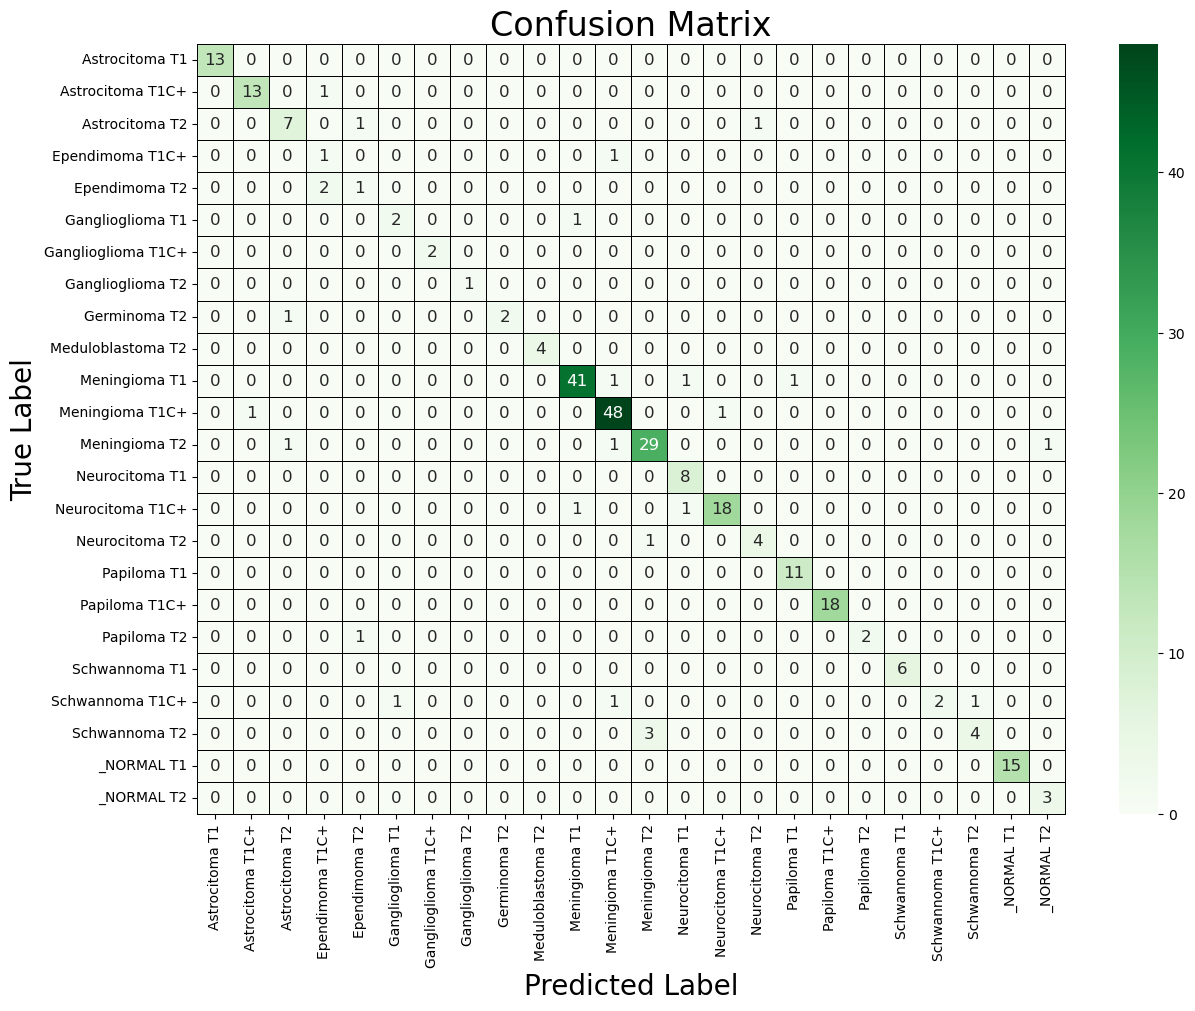

In [71]:
plot_confusion_matrix(
    test_df.label_encoded, 
    efficientnet_v2_test_predictions, 
    figsize=(14, 10),  
    classes=class_names)

### ViT-b16 Confusion Matrix

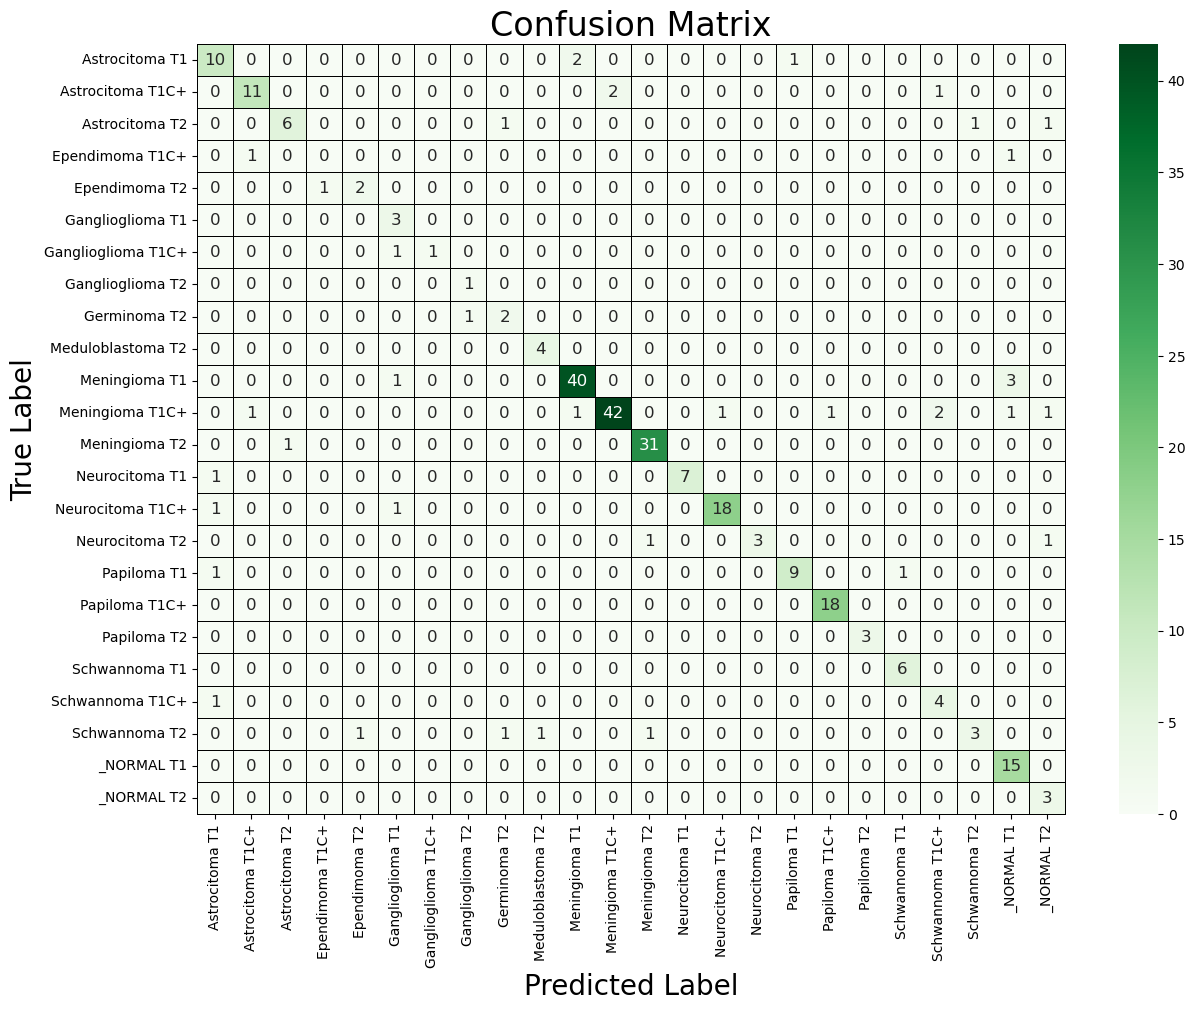

In [72]:
plot_confusion_matrix(
    test_df.label_encoded, 
    vit_b16_test_predictions, 
    figsize=(14, 10), 
    classes=class_names)

### Average Ensemble Confusion Matrix

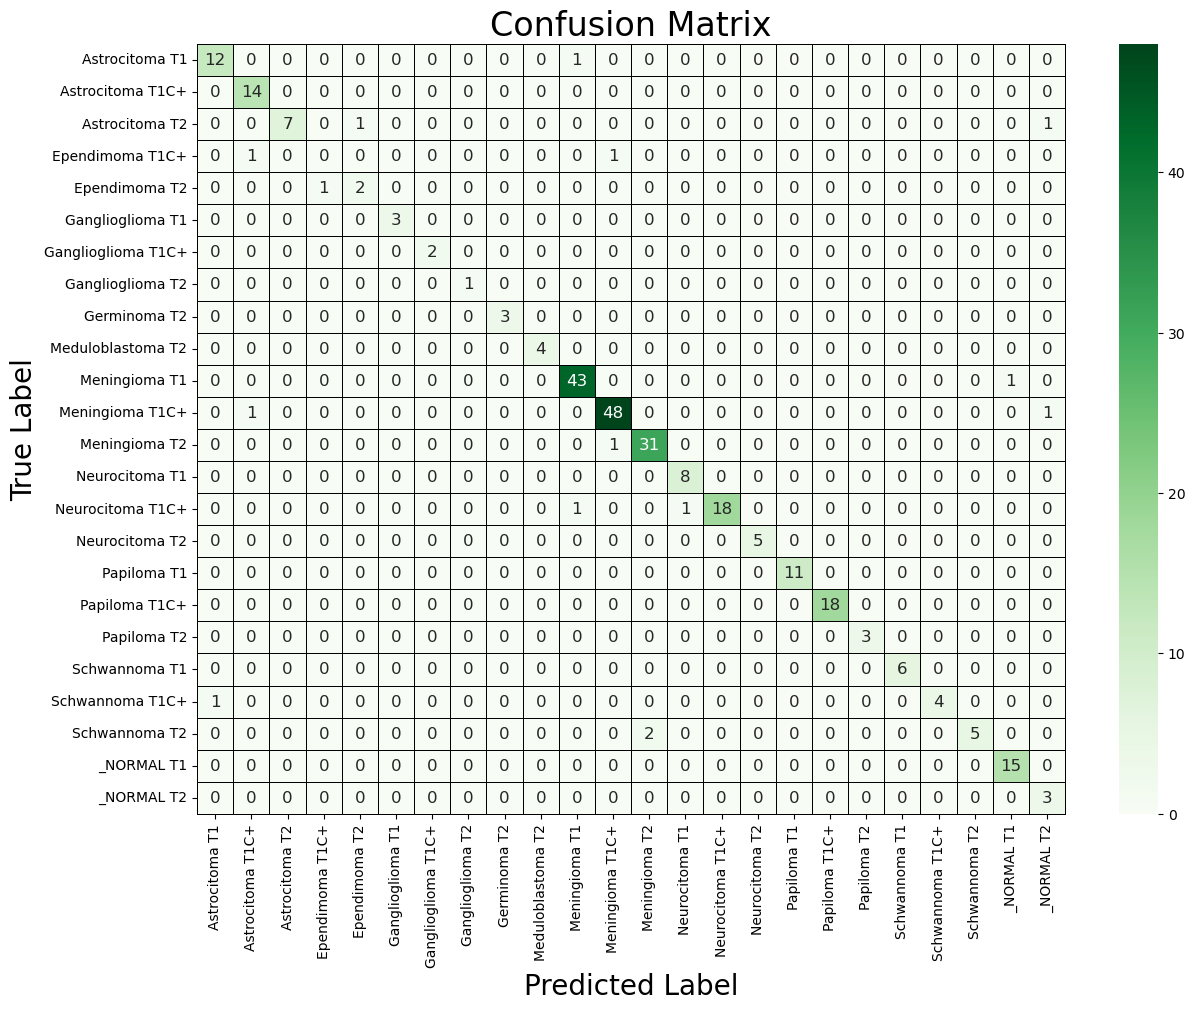

In [73]:
plot_confusion_matrix(
    test_df.label_encoded, 
    avg_predictions, 
    figsize=(14, 10), 
    classes=class_names)

### Weighted Average Ensemble Confusion Matrix

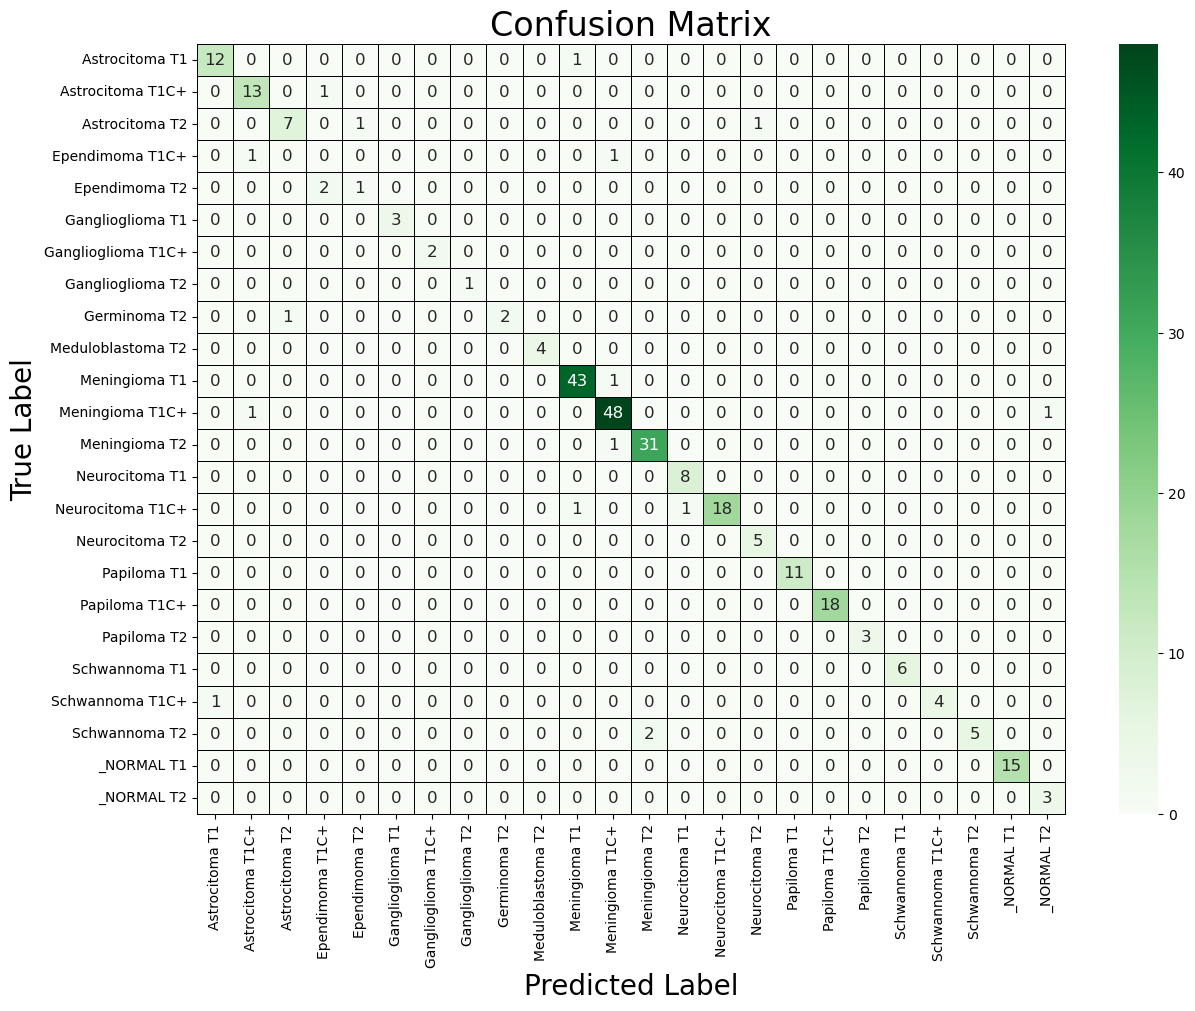

In [74]:
plot_confusion_matrix(
    test_df.label_encoded, 
    weighted_avg_predictions, 
    figsize=(14, 10), 
    classes=class_names)

### Geometric Mean Ensemble Confusion Matrix

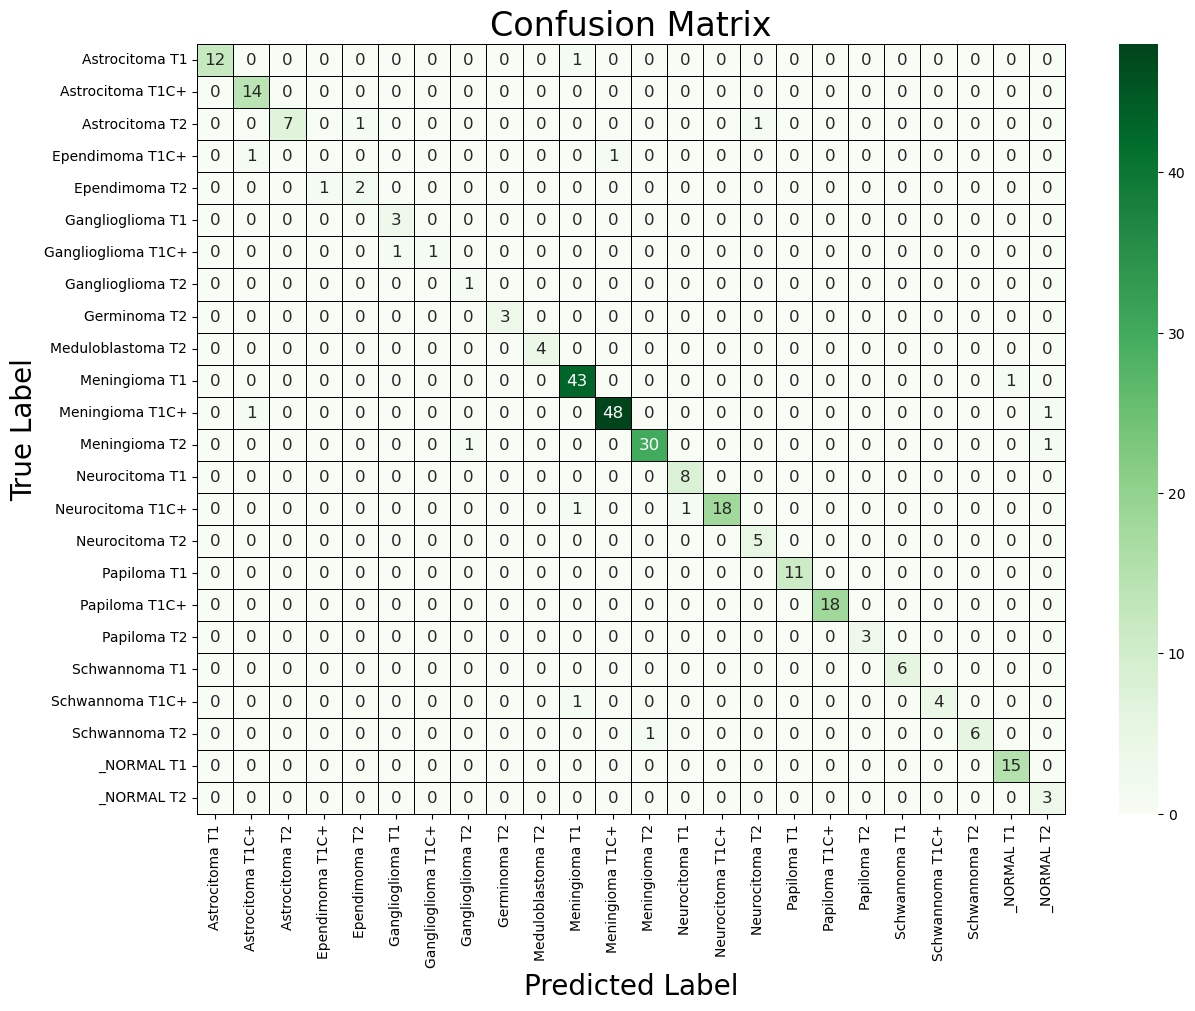

In [75]:
plot_confusion_matrix(
    test_df.label_encoded, 
    geometric_mean_predictions, 
    figsize=(14, 10), 
    classes=class_names)

<a id='6.3'></a>
### View Classification Reports

In [76]:
# EfficientNet V2 Report
print(classification_report(test_df.label_encoded, 
                            efficientnet_v2_test_predictions, 
                            target_names=class_names))

                    precision    recall  f1-score   support

    Astrocitoma T1       1.00      1.00      1.00        13
  Astrocitoma T1C+       0.93      0.93      0.93        14
    Astrocitoma T2       0.78      0.78      0.78         9
   Ependimoma T1C+       0.25      0.50      0.33         2
     Ependimoma T2       0.33      0.33      0.33         3
  Ganglioglioma T1       0.67      0.67      0.67         3
Ganglioglioma T1C+       1.00      1.00      1.00         2
  Ganglioglioma T2       1.00      1.00      1.00         1
      Germinoma T2       1.00      0.67      0.80         3
 Meduloblastoma T2       1.00      1.00      1.00         4
     Meningioma T1       0.95      0.93      0.94        44
   Meningioma T1C+       0.92      0.96      0.94        50
     Meningioma T2       0.88      0.91      0.89        32
    Neurocitoma T1       0.80      1.00      0.89         8
  Neurocitoma T1C+       0.95      0.90      0.92        20
    Neurocitoma T2       0.80      0.80

In [77]:
# ViT-b16 Report
print(classification_report(test_df.label_encoded, 
                            vit_b16_test_predictions, 
                            target_names=class_names))

                    precision    recall  f1-score   support

    Astrocitoma T1       0.71      0.77      0.74        13
  Astrocitoma T1C+       0.85      0.79      0.81        14
    Astrocitoma T2       0.86      0.67      0.75         9
   Ependimoma T1C+       0.00      0.00      0.00         2
     Ependimoma T2       0.67      0.67      0.67         3
  Ganglioglioma T1       0.50      1.00      0.67         3
Ganglioglioma T1C+       1.00      0.50      0.67         2
  Ganglioglioma T2       0.50      1.00      0.67         1
      Germinoma T2       0.50      0.67      0.57         3
 Meduloblastoma T2       0.80      1.00      0.89         4
     Meningioma T1       0.93      0.91      0.92        44
   Meningioma T1C+       0.95      0.84      0.89        50
     Meningioma T2       0.94      0.97      0.95        32
    Neurocitoma T1       1.00      0.88      0.93         8
  Neurocitoma T1C+       0.95      0.90      0.92        20
    Neurocitoma T2       1.00      0.60

In [78]:
# Average Ensemble Report
print(classification_report(test_df.label_encoded, 
                            avg_predictions, 
                            target_names=class_names))

                    precision    recall  f1-score   support

    Astrocitoma T1       0.92      0.92      0.92        13
  Astrocitoma T1C+       0.88      1.00      0.93        14
    Astrocitoma T2       1.00      0.78      0.88         9
   Ependimoma T1C+       0.00      0.00      0.00         2
     Ependimoma T2       0.67      0.67      0.67         3
  Ganglioglioma T1       1.00      1.00      1.00         3
Ganglioglioma T1C+       1.00      1.00      1.00         2
  Ganglioglioma T2       1.00      1.00      1.00         1
      Germinoma T2       1.00      1.00      1.00         3
 Meduloblastoma T2       1.00      1.00      1.00         4
     Meningioma T1       0.96      0.98      0.97        44
   Meningioma T1C+       0.96      0.96      0.96        50
     Meningioma T2       0.94      0.97      0.95        32
    Neurocitoma T1       0.89      1.00      0.94         8
  Neurocitoma T1C+       1.00      0.90      0.95        20
    Neurocitoma T2       1.00      1.00

In [79]:
# Weighted Average Ensemble Report
print(classification_report(test_df.label_encoded, 
                            weighted_avg_predictions, 
                            target_names=class_names))

                    precision    recall  f1-score   support

    Astrocitoma T1       0.92      0.92      0.92        13
  Astrocitoma T1C+       0.87      0.93      0.90        14
    Astrocitoma T2       0.88      0.78      0.82         9
   Ependimoma T1C+       0.00      0.00      0.00         2
     Ependimoma T2       0.50      0.33      0.40         3
  Ganglioglioma T1       1.00      1.00      1.00         3
Ganglioglioma T1C+       1.00      1.00      1.00         2
  Ganglioglioma T2       1.00      1.00      1.00         1
      Germinoma T2       1.00      0.67      0.80         3
 Meduloblastoma T2       1.00      1.00      1.00         4
     Meningioma T1       0.96      0.98      0.97        44
   Meningioma T1C+       0.94      0.96      0.95        50
     Meningioma T2       0.94      0.97      0.95        32
    Neurocitoma T1       0.89      1.00      0.94         8
  Neurocitoma T1C+       1.00      0.90      0.95        20
    Neurocitoma T2       0.83      1.00

In [80]:
# Geometric Mean Ensemble Report
print(classification_report(test_df.label_encoded, 
                            geometric_mean_predictions, 
                            target_names=class_names))

                    precision    recall  f1-score   support

    Astrocitoma T1       1.00      0.92      0.96        13
  Astrocitoma T1C+       0.88      1.00      0.93        14
    Astrocitoma T2       1.00      0.78      0.88         9
   Ependimoma T1C+       0.00      0.00      0.00         2
     Ependimoma T2       0.67      0.67      0.67         3
  Ganglioglioma T1       0.75      1.00      0.86         3
Ganglioglioma T1C+       1.00      0.50      0.67         2
  Ganglioglioma T2       0.50      1.00      0.67         1
      Germinoma T2       1.00      1.00      1.00         3
 Meduloblastoma T2       1.00      1.00      1.00         4
     Meningioma T1       0.93      0.98      0.96        44
   Meningioma T1C+       0.98      0.96      0.97        50
     Meningioma T2       0.97      0.94      0.95        32
    Neurocitoma T1       0.89      1.00      0.94         8
  Neurocitoma T1C+       1.00      0.90      0.95        20
    Neurocitoma T2       0.83      1.00

<div class="alert alert-block alert-info">
    <h3>Observe</h3>
    When comparing performance metrics, we observe that the EfficientNet model outperformed ViT-b16. The Geometric Mean Ensemble improved on the performance metrics when compared to both the ViT-b16, whilst slightly improving over EfficientNet, the Averege and Weighted Average Ensembles.
</div>

<a id='6.4'></a>
### Record Classification Metrics

In [81]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = accuracy_score(y_true, y_pred)
    top_3_accuracy = top_k_accuracy_score(y_true, y_probabilities, k=3)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, 
                                                                                 y_pred, 
                                                                                 average="weighted")
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')
    
    preformance_scores = {
        'accuracy_score': model_accuracy,
        'top_3_accuracy': top_3_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'f1_score': model_f1,
        'matthews_corrcoef': model_matthews_corrcoef
    }
    return preformance_scores


In [82]:
# Generate EfficieNet model performance scores
efficientnet_v2_performance = generate_preformance_scores(test_df.label_encoded,
                                                          efficientnet_v2_test_predictions, 
                                                          efficientnet_v2_test_probabilities)


Performance Metrics:

accuracy_score:		0.9075

_____________________________________________
top_3_accuracy_score:	0.9751

_____________________________________________
precision_score:	0.9146

_____________________________________________
recall_score:		0.9075

_____________________________________________
f1_score:		0.9065

_____________________________________________
matthews_corrcoef:	0.8982



In [83]:
# Generate ViT model performance scores
vit_b16_performance = generate_preformance_scores(test_df.label_encoded,
                                                  vit_b16_test_predictions, 
                                                  vit_b16_test_probabilities)


Performance Metrics:

accuracy_score:		0.8612

_____________________________________________
top_3_accuracy_score:	0.9537

_____________________________________________
precision_score:	0.8760

_____________________________________________
recall_score:		0.8612

_____________________________________________
f1_score:		0.8608

_____________________________________________
matthews_corrcoef:	0.8484



In [84]:
# Generate Average Ensemble performance scores
avg_ensemble_performance = generate_preformance_scores(test_df.label_encoded,
                                                       avg_predictions, 
                                                       avg_probabilities)


Performance Metrics:

accuracy_score:		0.9466

_____________________________________________
top_3_accuracy_score:	0.9786

_____________________________________________
precision_score:	0.9478

_____________________________________________
recall_score:		0.9466

_____________________________________________
f1_score:		0.9448

_____________________________________________
matthews_corrcoef:	0.9414



In [85]:
# Generate Weighted Average Ensemble performance scores
weigthed_avg_ensemble_performance = generate_preformance_scores(test_df.label_encoded,
                                                                weighted_avg_predictions, 
                                                                weighted_avg_probabilities)


Performance Metrics:

accuracy_score:		0.9359

_____________________________________________
top_3_accuracy_score:	0.9822

_____________________________________________
precision_score:	0.9402

_____________________________________________
recall_score:		0.9359

_____________________________________________
f1_score:		0.9359

_____________________________________________
matthews_corrcoef:	0.9295



In [86]:
# Generate Geometric Mean Ensemble performance scores
geometric_mean_ensemble_performance = generate_preformance_scores(test_df.label_encoded,
                                                                geometric_mean_predictions, 
                                                                geometric_mean_probabilities)


Performance Metrics:

accuracy_score:		0.9431

_____________________________________________
top_3_accuracy_score:	0.9893

_____________________________________________
precision_score:	0.9474

_____________________________________________
recall_score:		0.9431

_____________________________________________
f1_score:		0.9420

_____________________________________________
matthews_corrcoef:	0.9375



In [87]:
# Record metrics with DataFrame
performance_df = pd.DataFrame({
    'model_efficientnet_v2': efficientnet_v2_performance,
    'model_vit_b16': vit_b16_performance,
    'average_ensemble': avg_ensemble_performance,
    'weigthed_average_ensemble': weigthed_avg_ensemble_performance,
    'geometric_mean_ensemble': geometric_mean_ensemble_performance
}).T

# View Performance DataFrame
performance_df

,accuracy_score,top_3_accuracy,precision_score,recall_score,f1_score,matthews_corrcoef
model_efficientnet_v2,0.907473,0.975089,0.914624,0.907473,0.906549,0.898232
model_vit_b16,0.861210,0.953737,0.876029,0.861210,0.860811,0.848438
average_ensemble,0.946619,0.978648,0.947789,0.946619,0.944848,0.941353
weigthed_average_ensemble,0.935943,0.982206,0.940213,0.935943,0.935942,0.929520
geometric_mean_ensemble,0.943060,0.989324,0.947395,0.943060,0.941968,0.937531


<div class="alert alert-block alert-info">
    <h3>Observe</h3>
    We observe that the Geometric Mean Ensemble outperforms all other models on all metrics, especially with the Matthews Correlation Coefficient (MCC). A high MCC implies that the model's predictions are statistically of high quality and that the model does indeed generalise to unseen samples.
</div>

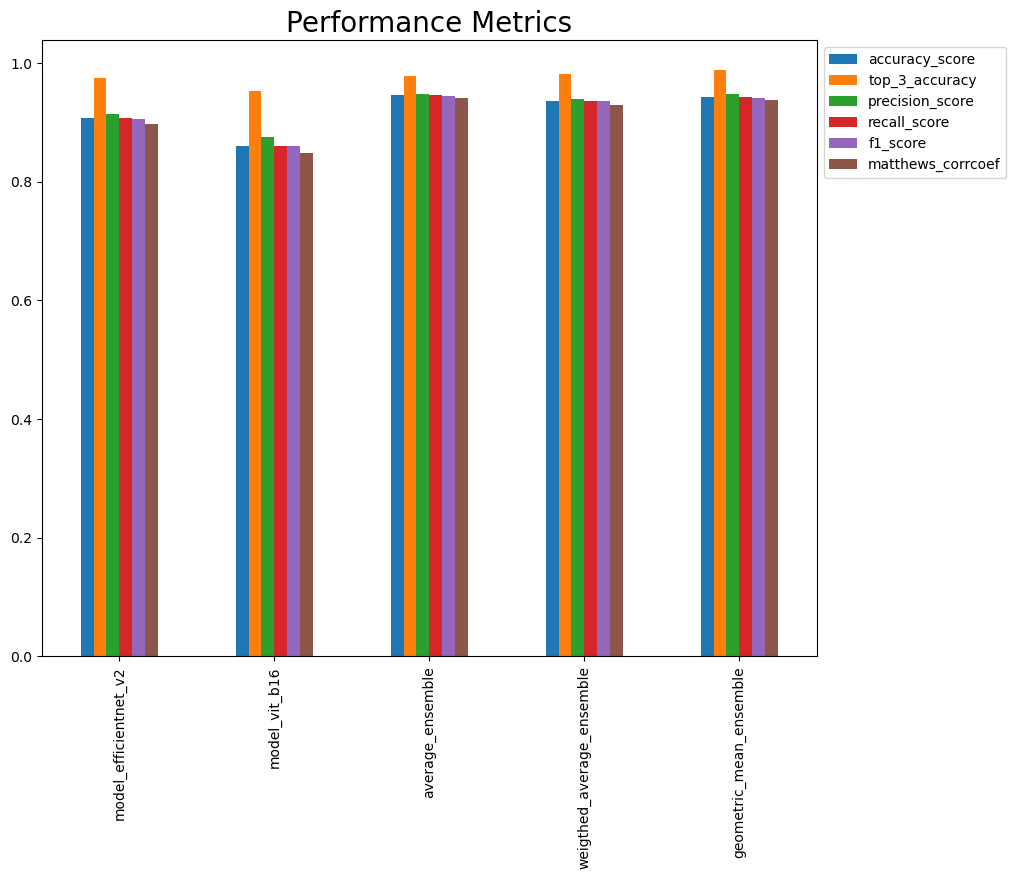

In [88]:
performance_df.plot(kind="bar", figsize=(10, 8)).legend(bbox_to_anchor=(1.0, 1.0))
plt.title('Performance Metrics', fontsize=20);

<a id='6.5'></a>
### Trade-offs: Inference Time vs. Performance
In order to decide which model would be best suited for usage in a real-world scenario we need to inspect the trade-offs related to each model by considering the time it takes to complete inference on a sample and how well it performs (how well the model generalises to unseen cases). We do this by measuring the average time it takes to infer a prediction for a given sample and plotting the inference time against a useful metrics.


<div class="alert alert-block alert-info">  
<h4>NOTE</h4> These results are not exactly reproducible since these measurements are influnced by hardware and system factors. For better measurement it is best to use more samples to calculate the average inference time and inference rate. This is to exploit the statistical phenomenon know as <a href='https://en.wikipedia.org/wiki/Regression_toward_the_mean'>mean reversion</a>. Using more samples may result in more computational effort being required.
</div>

In [89]:
def compute_inference_time(model, ds, sample_count, inference_runs=5):
    total_inference_times = []
    inference_rates = []
    
    for _ in range(inference_runs):
        start = time.perf_counter()
        model.predict(ds, verbose=0)
        end = time.perf_counter() 
        
        # Compute total inference time
        total_inference_time = end - start
        
        # Compute inference rate
        inference_rate = total_inference_time / sample_count
        
        total_inference_times.append(total_inference_time)
        inference_rates.append(inference_rate)
    
    # Calculate average total inference time with uncertainty
    avg_inference_time = sum(total_inference_times) / len(total_inference_times)
    avg_inference_time_uncertainty = (max(total_inference_times) - min(total_inference_times)) / 2
    
    # Calculate average inference rate with uncertainty
    avg_inference_rate = sum(inference_rates) / len(inference_rates)
    avg_inference_rate_uncertainty = (max(inference_rates) - min(inference_rates)) / 2
    
    print('====================================================')
    print(f'Model:\t\t{model.name}\n')
    print(f'Inference Time:\t{round(avg_inference_time, 6)}s \xB1 {round(avg_inference_time_uncertainty, 6)}s')
    print(f'Inference Rate:\t{round(avg_inference_rate, 6)}s/sample \xB1 {round(avg_inference_rate_uncertainty, 6)}s/sample')
    print('====================================================')
    
    return avg_inference_time, avg_inference_rate

In [90]:
efficientnet_v2_inference = compute_inference_time(model_efficientnet_v2, test_ds, len(test_df))

Model:		efficientnet_v2_sequential_model

Inference Time:	0.840794s ± 0.283668s
Inference Rate:	0.002992s/sample ± 0.001009s/sample


In [91]:
vit_b16_inference = compute_inference_time(model_vit_b16, test_ds, len(test_df))

Model:		vit_b16_sequential_model

Inference Time:	2.336281s ± 0.031383s
Inference Rate:	0.008314s/sample ± 0.000112s/sample


In [92]:
# We assume all ensembles to have the total inference of all models
ensemble_inference = (
    efficientnet_v2_inference[0] + vit_b16_inference[0],
    efficientnet_v2_inference[1] + vit_b16_inference[1]
)

print('====================================================')
print(f'Model:\t\tAverage/Weighted Average Ensemble\n')
print(f'Inference Time:\t{ensemble_inference[0]:.6f}s')
print(f'Inference Rate:\t{ensemble_inference[1]:.6f}s/sample')
print('====================================================')

Model:		Average/Weighted Average Ensemble

Inference Time:	3.177075s
Inference Rate:	0.011306s/sample


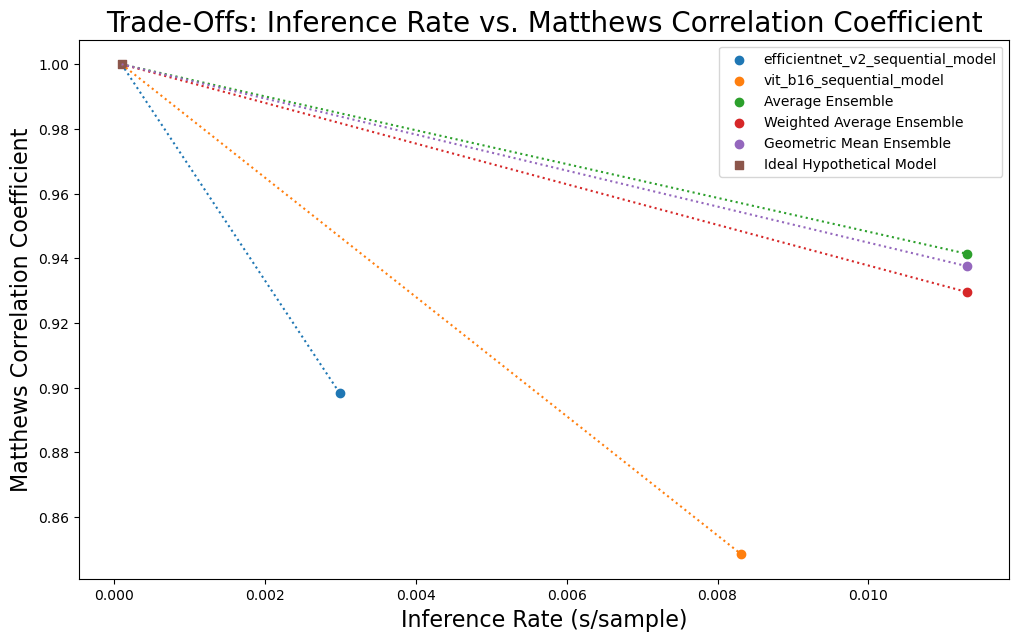

In [93]:
# Get MCC for each model
efficientnet_mcc = efficientnet_v2_performance["matthews_corrcoef"]
vit_mcc = vit_b16_performance["matthews_corrcoef"]
avg_mcc = avg_ensemble_performance['matthews_corrcoef']
weighted_mcc = weigthed_avg_ensemble_performance['matthews_corrcoef']
geometric_mcc = geometric_mean_ensemble_performance['matthews_corrcoef']

# Scatter plot inference rate against MCC
plt.figure(figsize=(12, 7))

# plt.scatter(cnn_inference[1], cnn_mcc, label=model_cnn.name)
plt.scatter(efficientnet_v2_inference[1], efficientnet_mcc, label=model_efficientnet_v2.name)
plt.scatter(vit_b16_inference[1], vit_mcc, label=model_vit_b16.name)
plt.scatter(ensemble_inference[1], avg_mcc, label='Average Ensemble')
plt.scatter(ensemble_inference[1], weighted_mcc, label='Weighted Average Ensemble')
plt.scatter(ensemble_inference[1], geometric_mcc, label='Geometric Mean Ensemble')

ideal_inference_rate = 0.0001 # Desired inference time (Exaggerated)
ideal_mcc = 1 # Max MCC 

# Plot lines connecting each model coords. to the ideal model coords.
plt.scatter(ideal_inference_rate, ideal_mcc, label="Ideal Hypothetical Model", marker='s')
plt.plot([ideal_inference_rate, efficientnet_v2_inference[1]], [ideal_mcc, efficientnet_mcc], ':')
plt.plot([ideal_inference_rate, vit_b16_inference[1]], [ideal_mcc, vit_mcc], ':')
plt.plot([ideal_inference_rate, ensemble_inference[1]], [ideal_mcc, avg_mcc], ':')
plt.plot([ideal_inference_rate, ensemble_inference[1]], [ideal_mcc, weighted_mcc], ':')
plt.plot([ideal_inference_rate, ensemble_inference[1]], [ideal_mcc, geometric_mcc], ':')

plt.legend()
plt.title("Trade-Offs: Inference Rate vs. Matthews Correlation Coefficient", fontsize=20)
plt.xlabel("Inference Rate (s/sample)", fontsize=16)
plt.ylabel("Matthews Correlation Coefficient", fontsize=16);

In [94]:
def dist(x1, x2, y1, y2):
    return np.sqrt(np.square(x2 - x1) + np.square(y2 - y1))

# List model names
model_names = [
    model_efficientnet_v2.name, 
    model_vit_b16.name,
    'Average Ensemble',
    'Weighted Average Ensemble',
    'Geometric Mean Ensemble'
]

# List model mcc scores
model_scores = [
    efficientnet_mcc, 
    vit_mcc,
    avg_mcc,
    weighted_mcc,
    geometric_mcc
]

# List model inference rates
model_rates = [
    efficientnet_v2_inference[1], 
    vit_b16_inference[1],
    ensemble_inference[1],
    ensemble_inference[1],
    ensemble_inference[1]
]

# Compute trade-off's
trade_offs = [dist(ideal_inference_rate, inference_rate, ideal_mcc, score) 
              for inference_rate, score in zip(model_rates, model_scores)]

# View model trade-off scores
print('Trade-Off Score: Inference Rate vs. MCC')
for name, inference_rate, score, trade in zip(model_names, model_rates, model_scores, trade_offs):
    print('---------------------------------------------------------')
    print(f'Model: {name}\n\nInference Rate: {inference_rate:.5f} | MCC: {score:.4f} | Trade-Off: {trade:.4f}')

# View model with best trade-off score
print('=========================================================')
best_model_trade = min(trade_offs)
best_model_name = model_names[np.argmin(trade_offs)]
print(f'\nBest Optimal Model:\t{best_model_name}\nTrade-Off:\t\t{best_model_trade:.4f}\n')
print('=========================================================')

Trade-Off Score: Inference Rate vs. MCC
---------------------------------------------------------
Model: efficientnet_v2_sequential_model

Inference Rate: 0.00299 | MCC: 0.8982 | Trade-Off: 0.1018
---------------------------------------------------------
Model: vit_b16_sequential_model

Inference Rate: 0.00831 | MCC: 0.8484 | Trade-Off: 0.1518
---------------------------------------------------------
Model: Average Ensemble

Inference Rate: 0.01131 | MCC: 0.9414 | Trade-Off: 0.0597
---------------------------------------------------------
Model: Weighted Average Ensemble

Inference Rate: 0.01131 | MCC: 0.9295 | Trade-Off: 0.0714
---------------------------------------------------------
Model: Geometric Mean Ensemble

Inference Rate: 0.01131 | MCC: 0.9375 | Trade-Off: 0.0635

Best Optimal Model:	Average Ensemble
Trade-Off:		0.0597



<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#B6EADA;
           font-size:100%;'>
    <a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a>
    </div>
</center>
           

<a id='conclusion'></a>
# <center>Conclusion</center>

<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/T1D2yGny/167.jpg); background-size: 100% auto;"></div>
              
<br>

In this notebook the usage of Transfer Learning models such EfficientNet V2 B0, ViT-B16 and ensembling methods were explored in order to solve the task of classifying multiple brain tumors in patients. The use **EfficientNet V2 B0 and ViT-B16 via Geometric Mean Ensembling** was shown to **outperform all other methods** covered in this notebook.

Regarding the inference-performance trade-offs, we observe that Geometric Mean Ensemble is the best choice as it outperforms all other models on the trade-off between inference time and performance as it achieves the highest Matthews Correlation Coefficient (MCC). This means that this Ensemble will generalise to unseen samples since a high MCC implies that model's predictions are statistically of high quality.

However, since the task is to classify multiple brain tumors it should be noted that a model trained to solve this problem should be trained on a significant number of samples and achieve a high accuracy score and MCC (very close to 100% and 1.0 respectively) as misclassification may result in a fatal outcome. A model for this task must achieve state-of-the-art (SOTA) performance if it is to be used in production as it will influence the decisions made by health professionals who diagnose brain tumors in patients. 

### Improving model performance

The models explored in this notebook still have room for improvement. The following should be considered:

- **Increasing the width and depth of the classification head:** Using more dense layers along with more units may result in improved performance, but may also hinder the inference rate.

- **Using Fine-Tuning techniques:** Fine-Tuning was not applied in this notebook to prevent adding to the complexity of the notebook. Applying fine-tuning methods may result in improved performance whilst maintaining similar inference rates. Note that this may require more computational resources and in the case of the Vision Transformer - lots of DATA as well!

- **Using Other Ensembling methods:** Ensembling via Averaging was explored in this notebook and proved to be a powerful technique which allows for the pooling of knowledge from various models all trained to solve the same problem (much like transfer learning). Improved results may be achived through ensembling techniques (such as blending, stacking or voting) at the expense of higher a inference rate.

- **Gather More Data:** The number of samples present in this dataset is insufficient since the structural information present which a model can learn is limited. By providing more data we will not only be able to build a model that can generalise better to unseen data, but with an influx of learnable structural information we'll be able to train a model that is robust to outliers, hence reducing the risk of misclassification. We'll also be able to apply fine-tuning techinique to vision transformer based models.

<div style="padding: 35px;color:white;margin:10;font-size:100%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/T1D2yGny/167.jpg); background-size: 100% auto;background-position: 0px 500px; 
">
    <span style='color:white;'>
     <center>
    <h2><b>To you, the notebook visitor...</b></h2>
    <b>It takes a lot of effort and time from me to create my notebooks. 
    <br>
    So, if you <u>FORK or found this notebook HELPFUL</u>, please consider supporting me with an upvote! 
    <br>
    I truly appreciate your time and attention!😊</b>
<h3>Once again, thank you for visiting my notebook!🙏</h3></center></span>

</div>